# Notebook de análisis (5 análisis de `analisis/old`)

Este notebook agrupa y ordena los 5 análisis históricos de la carpeta `analisis/old` en una secuencia reproducible.

Objetivo:
- Cargar los CSV de benchmark.
- Reutilizar una sola vez imports/carga/helpers.
- Ejecutar cada análisis en su propia celda (sin duplicar código) y con explicación de qué se hace y por qué sirve.

## 0) Configuración

Esta celda define rutas y parámetros comunes.

Sirve para:
- Evitar hardcodear rutas en cada análisis.
- Hacer el notebook más reproducible si se ejecuta desde otra carpeta.

In [85]:
from pathlib import Path

# El notebook está en `analisis/`. Normalmente los CSV están en esta carpeta
# o en la raíz del proyecto.
NOTEBOOK_DIR = Path.cwd()
SEARCH_DIRS = [NOTEBOOK_DIR, NOTEBOOK_DIR.parent]

CSV_GRANULAR = "benchmark_granular.csv"
CSV_RESULTS = "benchmark_results.csv"  # opcional (algunos análisis antiguos lo usan)

# Parámetro físico aproximado usado por algunos análisis antiguos
L3_APPROX_BYTES = 20 * 1024 * 1024
INT_BYTES = 4
L3_APPROX_ELEMENTS = L3_APPROX_BYTES // INT_BYTES

L3_APPROX_ELEMENTS

5242880

## 1) Imports + carga de datos + helpers (sin repetición)

Esta celda concentra todo lo reutilizable:
- imports
- funciones de carga robusta (busca el CSV en `analisis/` y en la raíz)
- helpers de filtrado/métricas/plots

Sirve para que los 5 análisis siguientes sean celdas cortas que llaman helpers.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 10})


def _find_csv(name: str, search_dirs: list[Path]) -> Path | None:
    for d in search_dirs:
        p = d / name
        if p.exists():
            return p
    return None


def load_csv(name: str, search_dirs: list[Path]) -> pd.DataFrame | None:
    p = _find_csv(name, search_dirs)
    if p is None:
        print(f"No encontrado: {name} (buscado en: {[str(d) for d in search_dirs]})")
        return None
    return pd.read_csv(p)


def ensure_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


def load_granular() -> pd.DataFrame | None:
    df = load_csv(CSV_GRANULAR, SEARCH_DIRS)
    if df is None:
        return None
    df = ensure_numeric(
        df,
        [
            "Threads",
            "InputSize",
            "TotalTime",
            "SortPhase",
            "PivotPhase",
            "SubpartPhase",
            "OffsetPhase",
            "MergePhase",
        ],
    )
    return df


def load_results() -> pd.DataFrame | None:
    df = load_csv(CSV_RESULTS, SEARCH_DIRS)
    if df is None:
        return None
    df = ensure_numeric(df, ["Threads", "InputSize", "TimeSeconds"])
    return df


def only_samplemerge(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["Algorithm"] == "SampleMerge"].copy()


def add_size_label(df: pd.DataFrame, col: str = "InputSize") -> pd.DataFrame:
    df = df.copy()
    df["SizeLabel"] = df[col].apply(lambda x: f"{x:.0e}")
    return df


def effective_bandwidth_gbs(input_size: pd.Series, merge_ms: pd.Series, elem_bytes: int = 4) -> pd.Series:
    # GB/s = (N * bytes) / (time_ms * 1e-3) / 1e9
    return (input_size * elem_bytes) / (merge_ms * 1e-3) / 1e9


def ols_fit(y: pd.Series, x: pd.Series):
    return sm.OLS(y, sm.add_constant(x)).fit()


def is_nonempty(df: pd.DataFrame | None) -> bool:
    return df is not None and not df.empty


df_granular = load_granular()
df_results = load_results()

print("df_granular:", None if df_granular is None else df_granular.shape)
print("df_results:", None if df_results is None else df_results.shape)

df_granular: (7560, 10)
df_results: (304, 5)


## 1.1) Helpers adicionales (filtros y validación)

Sirve para:
- Reutilizar filtros típicos (SampleMerge/Distribución/Tamaño/Hilos) en los 5 análisis.
- Hacer que las celdas de análisis sean cortas y legibles.

In [87]:
def require_columns(df: pd.DataFrame, cols: list[str], df_name: str = "df") -> bool:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"Faltan columnas en {df_name}: {missing}")
        return False
    return True


def max_input_size(df: pd.DataFrame) -> int:
    return int(pd.to_numeric(df["InputSize"], errors="coerce").max())


def subset_granular(
    df: pd.DataFrame,
    algorithm: str | None = None,
    distribution: str | None = None,
    threads: int | None = None,
    input_size: int | None = None,
) -> pd.DataFrame:
    out = df.copy()
    if algorithm is not None:
        out = out[out["Algorithm"] == algorithm]
    if distribution is not None:
        out = out[out["Distribution"] == distribution]
    if threads is not None:
        out = out[out["Threads"] == threads]
    if input_size is not None:
        out = out[out["InputSize"] == input_size]
    return out.copy()


def show_or_explain(condition: bool, message: str):
    if not condition:
        print(message)

print("Helpers adicionales listos.")

Helpers adicionales listos.


## 2) Análisis 1 — Vista general (benchmark_results.csv)

Basado en `plot_results.py`.

Sirve para:
- Ver la tendencia global tiempo vs tamaño.
- Comparar speedup contra `std::sort`.
- Ver strong scaling y efecto de la distribución (Uniform vs Normal).

Nota: Este análisis usa `benchmark_results.csv` (si no existe, se omite).

Figura A: benchmark_results.csv (ok: ratio≈0.964)


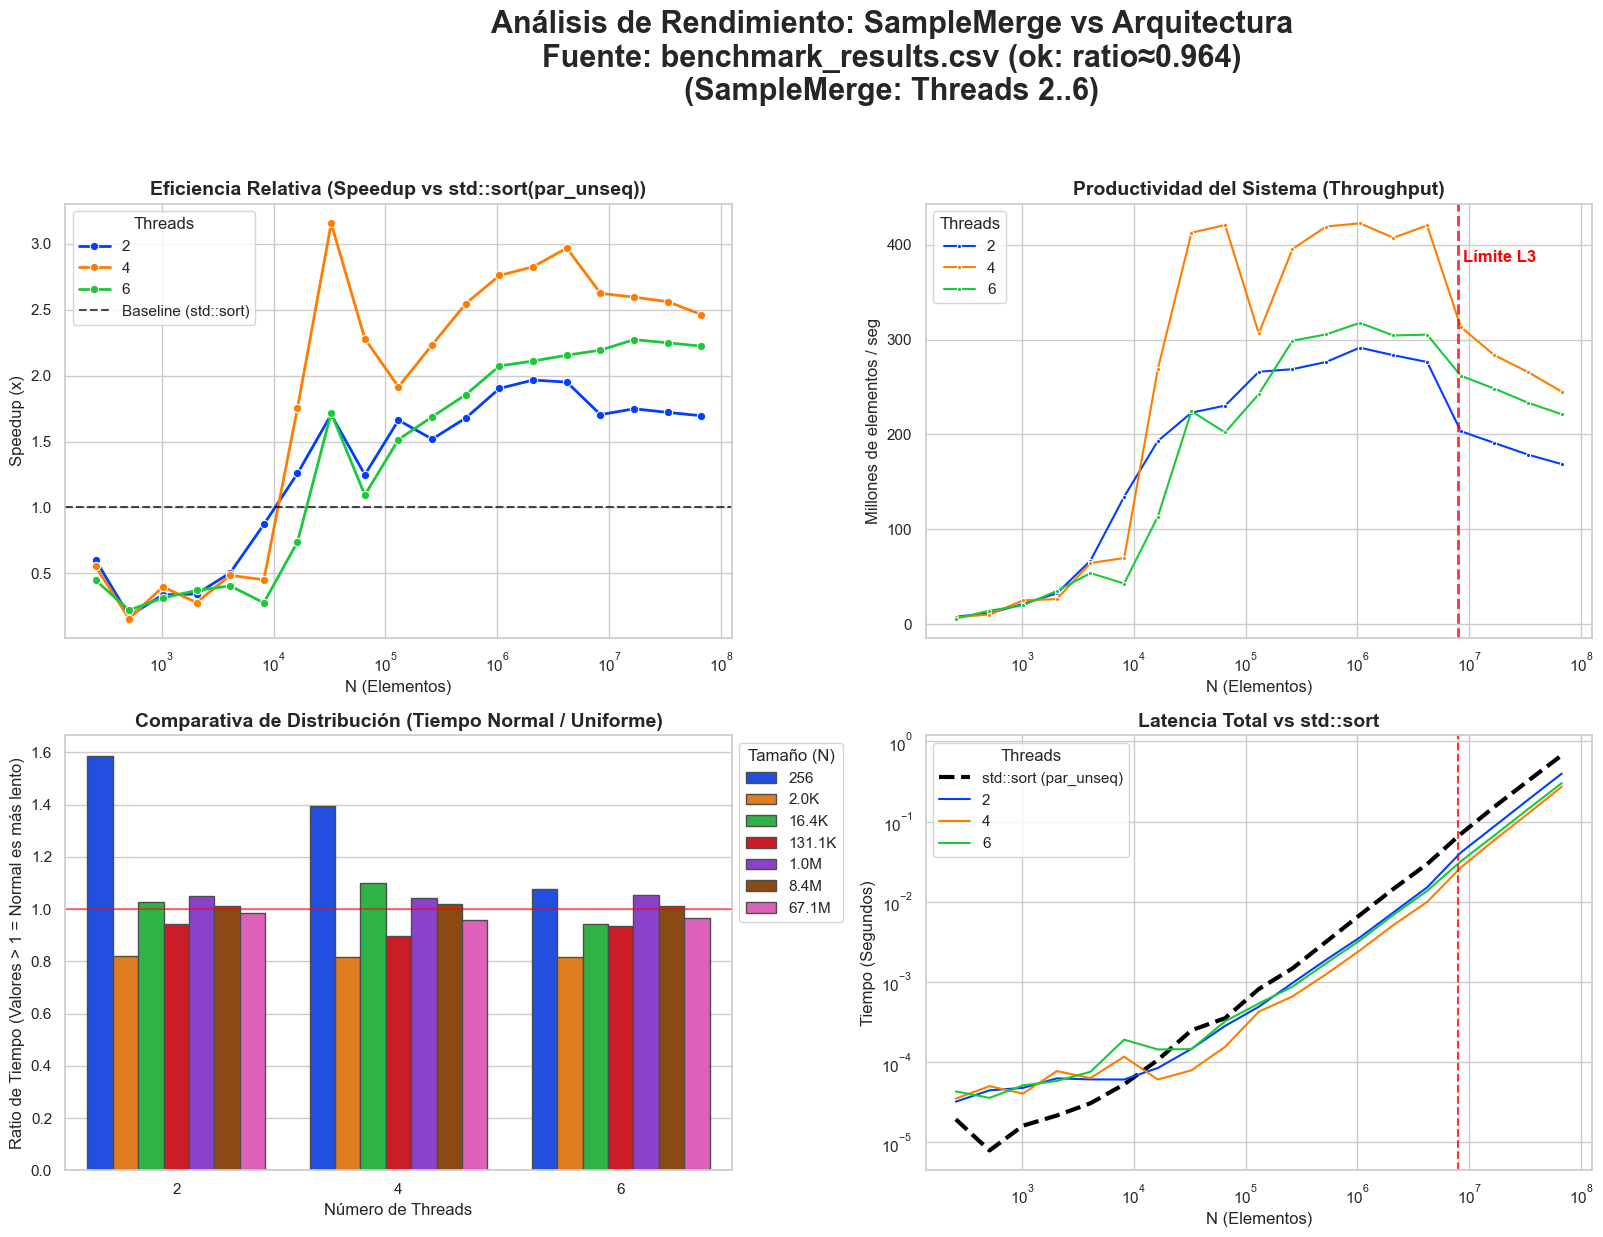

In [88]:
# Análisis 1 (general): gráfico 2x2 basado en benchmark_results.csv.
# Nota: se mantiene (si existe) una validación de unidades contra benchmark_granular.csv,
# pero NO se grafica una segunda figura con granular.

def _granular_as_results(df_g: pd.DataFrame) -> pd.DataFrame | None:
    needed = ["Algorithm", "Distribution", "Threads", "InputSize", "TotalTime"]
    if not is_nonempty(df_g) or not require_columns(df_g, needed, "df_granular"):
        return None

    df_tmp = df_g[needed].copy()
    df_tmp["TimeSeconds"] = df_tmp["TotalTime"] / 1000.0

    # En granular hay múltiples filas por punto: agregamos por mediana
    return (
        df_tmp.groupby(["Algorithm", "Distribution", "Threads", "InputSize"], as_index=False)["TimeSeconds"]
        .median()
    )


def _maybe_fix_units_using_granular(df_r: pd.DataFrame, df_g: pd.DataFrame) -> tuple[pd.DataFrame, str]:
    """Ajusta unidades de TimeSeconds si detecta que está en ms comparándolo con granular (en segundos)."""
    df_ref = _granular_as_results(df_g)
    if df_ref is None or df_ref.empty:
        return df_r, "(sin validación contra granular)"

    keys = ["Algorithm", "Distribution", "Threads", "InputSize"]
    merged = df_r.merge(df_ref, on=keys, suffixes=("_r", "_g"))
    merged = merged.dropna(subset=["TimeSeconds_r", "TimeSeconds_g"])

    if merged.empty:
        return df_r, "(sin puntos comunes para validar)"

    ratio = (merged["TimeSeconds_r"] / merged["TimeSeconds_g"]).replace([np.inf, -np.inf], np.nan).dropna()
    if ratio.empty:
        return df_r, "(validación sin ratio utilizable)"

    med_ratio = float(ratio.median())

    # Heurística: si está cerca de 1000 -> df_r está en milisegundos
    if 800 <= med_ratio <= 1200:
        df_fixed = df_r.copy()
        df_fixed["TimeSeconds"] = df_fixed["TimeSeconds"] / 1000.0
        return df_fixed, f"(corregido: TimeSeconds parecía estar en ms; ratio≈{med_ratio:.1f})"

    return df_r, f"(ok: ratio≈{med_ratio:.3g})"


def format_n_label(n):
    """Formatea N para que sea legible en tamaños pequeños (K) y grandes (M)."""
    if n >= 1e6:
        return f"{n/1e6:.1f}M"
    elif n >= 1e3:
        return f"{n/1e3:.1f}K"
    else:
        return str(int(n))


def _plot_thesis_final_v2(df: pd.DataFrame, title_suffix: str, t_min: int = 2, t_max: int = 6):
    # --- 1. Preparación de Datos ---
    df = df.copy()
    for col in ["Threads", "InputSize", "TimeSeconds"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=["Algorithm", "Distribution", "Threads", "InputSize", "TimeSeconds"])

    # Baseline: std::sort (usamos Uniform)
    std_base = df[(df["Algorithm"] == "std::sort") & (df["Distribution"] == "Uniform")]
    std_base = std_base.groupby("InputSize")["TimeSeconds"].median().reset_index()
    std_base.rename(columns={"TimeSeconds": "T_std"}, inplace=True)

    # SampleMerge
    df_sm = df[(df["Algorithm"] == "SampleMerge") & (df["Threads"] >= t_min) & (df["Threads"] <= t_max)].copy()
    df_sm = df_sm.merge(std_base, on="InputSize")
    df_sm["Speedup"] = df_sm["T_std"] / df_sm["TimeSeconds"]
    df_sm["Throughput"] = (df_sm["InputSize"] / df_sm["TimeSeconds"]) / 1e6

    # --- 2. Configuración Global ---
    sns.set_theme(style="whitegrid")
    # Límite L3 Ryzen 5600X (32MB / 4 bytes por int = 8M elementos)
    l3_limit = 8e6
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 13))
    fig.suptitle(f"Análisis de Rendimiento: SampleMerge vs Arquitectura\n{title_suffix}\n(SampleMerge: Threads {t_min}..{t_max})", fontsize=22, fontweight='bold')

    # ========================================================
    # 1. SPEEDUP VS N (Eje X = N, Líneas = Threads)
    # ========================================================
    ax1 = axes[0, 0]
    data_speed = df_sm[df_sm["Distribution"] == "Uniform"].sort_values(["Threads", "InputSize"])
    sns.lineplot(data=data_speed, x="InputSize", y="Speedup", hue="Threads",
                 palette="bright", marker="o", linewidth=2, ax=ax1)
    
    ax1.axhline(1.0, color="black", linestyle="--", alpha=0.7, label="Baseline (std::sort)")
    ax1.set_xscale("log")
    ax1.set_xlabel("N (Elementos)")
    ax1.set_title("Eficiencia Relativa (Speedup vs std::sort(par_unseq))", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Speedup (x)")
    ax1.legend(title="Threads", loc="upper left", frameon=True)

    # ========================================================
    # 2. THROUGHPUT CON LÍMITE L3
    # ========================================================
    ax2 = axes[0, 1]
    sns.lineplot(data=df_sm[df_sm["Distribution"] == "Uniform"], x="InputSize", y="Throughput",
                 hue="Threads", palette="bright", marker=".", ax=ax2)
    
    ax2.axvline(x=l3_limit, color='red', linestyle='--', alpha=0.8, linewidth=2)
    ax2.text(l3_limit*1.1, df_sm["Throughput"].max()*0.9, "Límite L3", color='red', fontweight='bold')
    
    ax2.set_xscale("log")
    ax2.set_title("Productividad del Sistema (Throughput)", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Millones de elementos / seg")
    ax2.set_xlabel("N (Elementos)")

    # ========================================================
    # 3. SENSIBILIDAD A DISTRIBUCIÓN (Barras Agrupadas)
    # ========================================================
    ax3 = axes[1, 0]
    dist_pivot = df_sm.pivot_table(index=["Threads", "InputSize"],
                                   columns="Distribution", values="TimeSeconds").reset_index()
    
    if "Normal" in dist_pivot.columns and "Uniform" in dist_pivot.columns:
        dist_pivot["Ratio"] = dist_pivot["Normal"] / dist_pivot["Uniform"]
        
        # Seleccionamos 6-7 tamaños para que las barras sean legibles
        u_sizes = sorted(dist_pivot["InputSize"].unique())
        idx = np.unique(np.linspace(0, len(u_sizes) - 1, 7, dtype=int))
        chosen_sizes = [u_sizes[i] for i in idx]
        
        data_bar = dist_pivot[dist_pivot["InputSize"].isin(chosen_sizes)].copy()
        data_bar["N_Label"] = data_bar["InputSize"].apply(format_n_label)
        
        sns.barplot(data=data_bar, x="Threads", y="Ratio", hue="N_Label",
                    ax=ax3, palette="bright", edgecolor="0.3")
        
        ax3.axhline(1.0, color="red", linestyle="-", alpha=0.5)
        ax3.set_title("Comparativa de Distribución (Tiempo Normal / Uniforme)", fontsize=14, fontweight='bold')
        ax3.set_ylabel("Ratio de Tiempo (Valores > 1 = Normal es más lento)")
        ax3.set_xlabel("Número de Threads")
        ax3.legend(title="Tamaño (N)", loc="upper left", bbox_to_anchor=(1, 1))

    # ========================================================
    # 4. TIEMPO DE EJECUCIÓN (Incluyendo std::sort)
    # ========================================================
    ax4 = axes[1, 1]
    sns.lineplot(data=std_base, x="InputSize", y="T_std", color="black",
                 linewidth=3, linestyle="--", label="std::sort (par_unseq)", ax=ax4)
    sns.lineplot(data=df_sm[df_sm["Distribution"] == "Uniform"],
                 x="InputSize", y="TimeSeconds", hue="Threads",
                 palette="bright", ax=ax4)
    
    ax4.axvline(x=l3_limit, color='red', linestyle='--', alpha=0.8)
    ax4.set_xscale("log")
    ax4.set_yscale("log")
    ax4.set_title("Latencia Total vs std::sort", fontsize=14, fontweight='bold')
    ax4.set_ylabel("Tiempo (Segundos)")
    ax4.set_xlabel("N (Elementos)")

    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
    plt.show()


if is_nonempty(df_results):
    df_r, unit_note = _maybe_fix_units_using_granular(df_results.copy(), df_granular)
    print("Figura A:", "benchmark_results.csv", unit_note)
    _plot_thesis_final_v2(df_r, title_suffix=f"Fuente: benchmark_results.csv {unit_note}", t_min=2, t_max=6)
else:
    print("Figura: omitida (no existe benchmark_results.csv o está vacío)")

## 3) Análisis 2 — Análisis avanzado granular (fases, speedup, regresión, distribución)

Basado en `analyze_results.py`.

Sirve para:
- Entender qué fase domina al aumentar threads (stacked bar en N máximo).
- Ver speedup total vs speedup de Sort/Merge por separado.
- Validar modelos teóricos con regresión y diagnosticar residuos.
- Comparar Uniforme vs Normal en tiempo total.

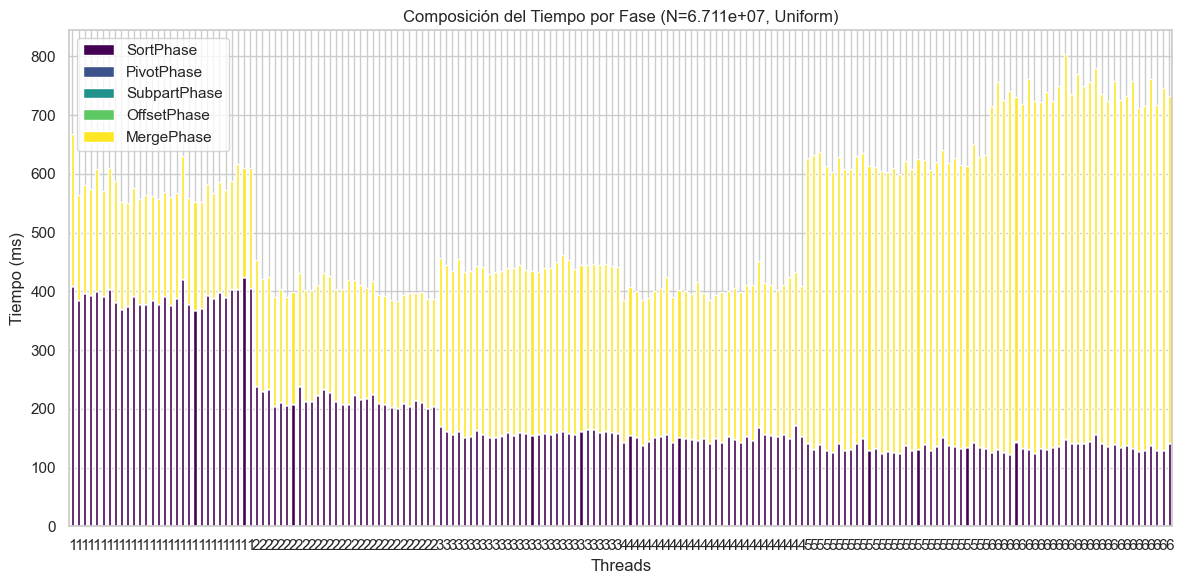

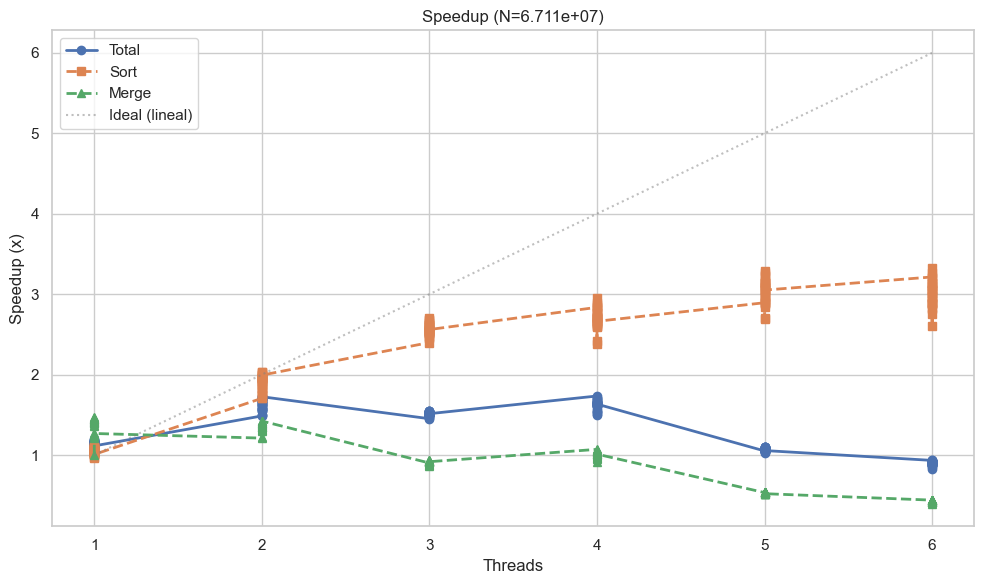

In [89]:
if not is_nonempty(df_granular):
    print("Saltando Análisis 2: no existe 'benchmark_granular.csv' o está vacío.")
else:
    show_or_explain(
        require_columns(
            df_granular,
            [
                "Algorithm",
                "Distribution",
                "Threads",
                "InputSize",
                "TotalTime",
                "SortPhase",
                "PivotPhase",
                "SubpartPhase",
                "OffsetPhase",
                "MergePhase",
            ],
            "df_granular",
        ),
        "df_granular no tiene el formato esperado",
    )

    df = subset_granular(df_granular, algorithm="SampleMerge")

    # =====================
    # PARTE 1: fases (stacked)
    # =====================
    max_size = max_input_size(df)
    df_max_uni = subset_granular(df, distribution="Uniform", input_size=max_size)
    phases = ["SortPhase", "PivotPhase", "SubpartPhase", "OffsetPhase", "MergePhase"]

    if df_max_uni.empty:
        print("No hay datos SampleMerge/Uniform para el N máximo.")
    else:
        fig1, ax1 = plt.subplots(figsize=(12, 6))
        df_plot = df_max_uni.set_index("Threads")[phases].sort_index()
        df_plot.plot(kind="bar", stacked=True, ax=ax1, colormap="viridis")
        ax1.set_title(f"Composición del Tiempo por Fase (N={max_size:.3e}, Uniform)")
        ax1.set_ylabel("Tiempo (ms)")
        ax1.set_xlabel("Threads")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # =====================
        # PARTE 2: speedups (total vs fases)
        # =====================
        min_thread = int(df_max_uni["Threads"].min())
        base_row = df_max_uni[df_max_uni["Threads"] == min_thread].iloc[0]

        df_su = df_max_uni.copy().sort_values("Threads")
        df_su["Speedup_Total"] = base_row["TotalTime"] / df_su["TotalTime"]
        df_su["Speedup_Sort"] = base_row["SortPhase"] / df_su["SortPhase"]
        df_su["Speedup_Merge"] = base_row["MergePhase"] / df_su["MergePhase"]

        fig2, ax2 = plt.subplots(figsize=(10, 6))
        ax2.plot(df_su["Threads"], df_su["Speedup_Total"], marker="o", label="Total", linewidth=2)
        ax2.plot(df_su["Threads"], df_su["Speedup_Sort"], marker="s", linestyle="--", label="Sort", linewidth=2)
        ax2.plot(df_su["Threads"], df_su["Speedup_Merge"], marker="^", linestyle="--", label="Merge", linewidth=2)

        ax2.plot(
            [min_thread, int(df_su["Threads"].max())],
            [1, int(df_su["Threads"].max()) / min_thread],
            color="gray",
            alpha=0.5,
            linestyle=":",
            label="Ideal (lineal)",
        )

        ax2.set_title(f"Speedup (N={max_size:.3e})")
        ax2.set_xlabel("Threads")
        ax2.set_ylabel("Speedup (x)")
        ax2.legend()
        plt.tight_layout()
        plt.show()

## 4) Análisis 4 — Caché vs RAM (regresión segmentada)

Basado en `bandwith 4t.py` (nombre histórico).

Sirve para:
- Separar el comportamiento “in-cache” vs “out-of-cache” usando un umbral de L3.
- Ajustar regresiones por régimen para cuantificar el cambio de pendiente.
- Ver si el modelo $Merge \approx N\log_2(Threads)$ se comporta distinto al salir de caché.


ANÁLISIS SEGMENTADO (Caché vs RAM)

>>> Régimen: In-Cache (L3)
    R-squared: 0.8033
    Pendiente: 2.13e-06
    Cond. No.: 1.92e+06

>>> Régimen: Out-of-Cache (RAM)
    R-squared: 0.6431
    Pendiente: 1.63e-06
    Cond. No.: 7.23e+07


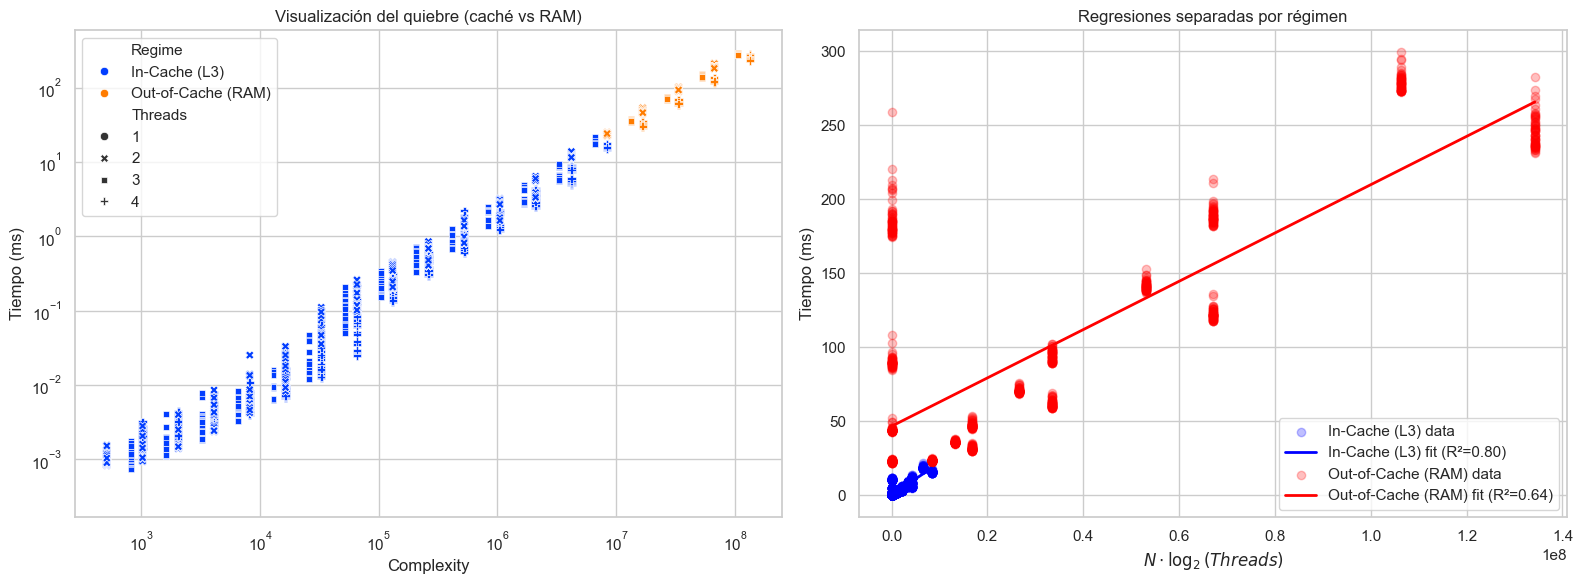

In [90]:
if not is_nonempty(df_granular):
    print("Saltando Análisis 4: no existe 'benchmark_granular.csv' o está vacío.")
else:
    df = subset_granular(df_granular, algorithm="SampleMerge")

    # Región escalable original: Threads <= 4
    df = df[df["Threads"] <= 4].copy()

    CACHE_THRESHOLD = int(L3_APPROX_ELEMENTS)  # ~20MB / 4 bytes
    df["Regime"] = np.where(df["InputSize"] < CACHE_THRESHOLD, "In-Cache (L3)", "Out-of-Cache (RAM)")

    # Modelo del script: N * log2(Threads)
    df["Complexity"] = df["InputSize"] * np.log2(df["Threads"])

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(data=df, x="Complexity", y="MergePhase", hue="Regime", style="Threads", ax=ax[0], palette="bright")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].set_title("Visualización del quiebre (caché vs RAM)")
    ax[0].set_ylabel("Tiempo (ms)")

    print("\n" + "=" * 50)
    print("ANÁLISIS SEGMENTADO (Caché vs RAM)")
    print("=" * 50)

    colors = {"In-Cache (L3)": "blue", "Out-of-Cache (RAM)": "red"}

    for regime in ["In-Cache (L3)", "Out-of-Cache (RAM)"]:
        subset = df[df["Regime"] == regime].copy()
        if subset.empty:
            continue

        X = subset["Complexity"]
        y = subset["MergePhase"]
        model = ols_fit(y, X)

        print(f"\n>>> Régimen: {regime}")
        print(f"    R-squared: {model.rsquared:.4f}")
        print(f"    Pendiente: {model.params.iloc[1]:.2e}")
        print(f"    Cond. No.: {model.condition_number:.2e}")

        ax[1].scatter(X, y, color=colors[regime], alpha=0.25, label=f"{regime} data")

        x_pred = np.linspace(X.min(), X.max(), 200)
        y_pred = model.params.iloc[0] + model.params.iloc[1] * x_pred
        ax[1].plot(x_pred, y_pred, color=colors[regime], linewidth=2, label=f"{regime} fit (R²={model.rsquared:.2f})")

    ax[1].set_title("Regresiones separadas por régimen")
    ax[1].set_xlabel(r"$N \cdot \log_2(Threads)$")
    ax[1].set_ylabel("Tiempo (ms)")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

Iniciando generación de gráficos para 6 configuraciones de hilos...
  - Threads 1: 540 puntos (10^4 < N < 8M) | 300 puntos (fuera de rango)
  - Threads 2: 540 puntos (10^4 < N < 8M) | 300 puntos (fuera de rango)
  - Threads 3: 540 puntos (10^4 < N < 8M) | 300 puntos (fuera de rango)
  - Threads 4: 540 puntos (10^4 < N < 8M) | 300 puntos (fuera de rango)
  - Threads 5: 540 puntos (10^4 < N < 8M) | 300 puntos (fuera de rango)
  - Threads 6: 540 puntos (10^4 < N < 8M) | 300 puntos (fuera de rango)


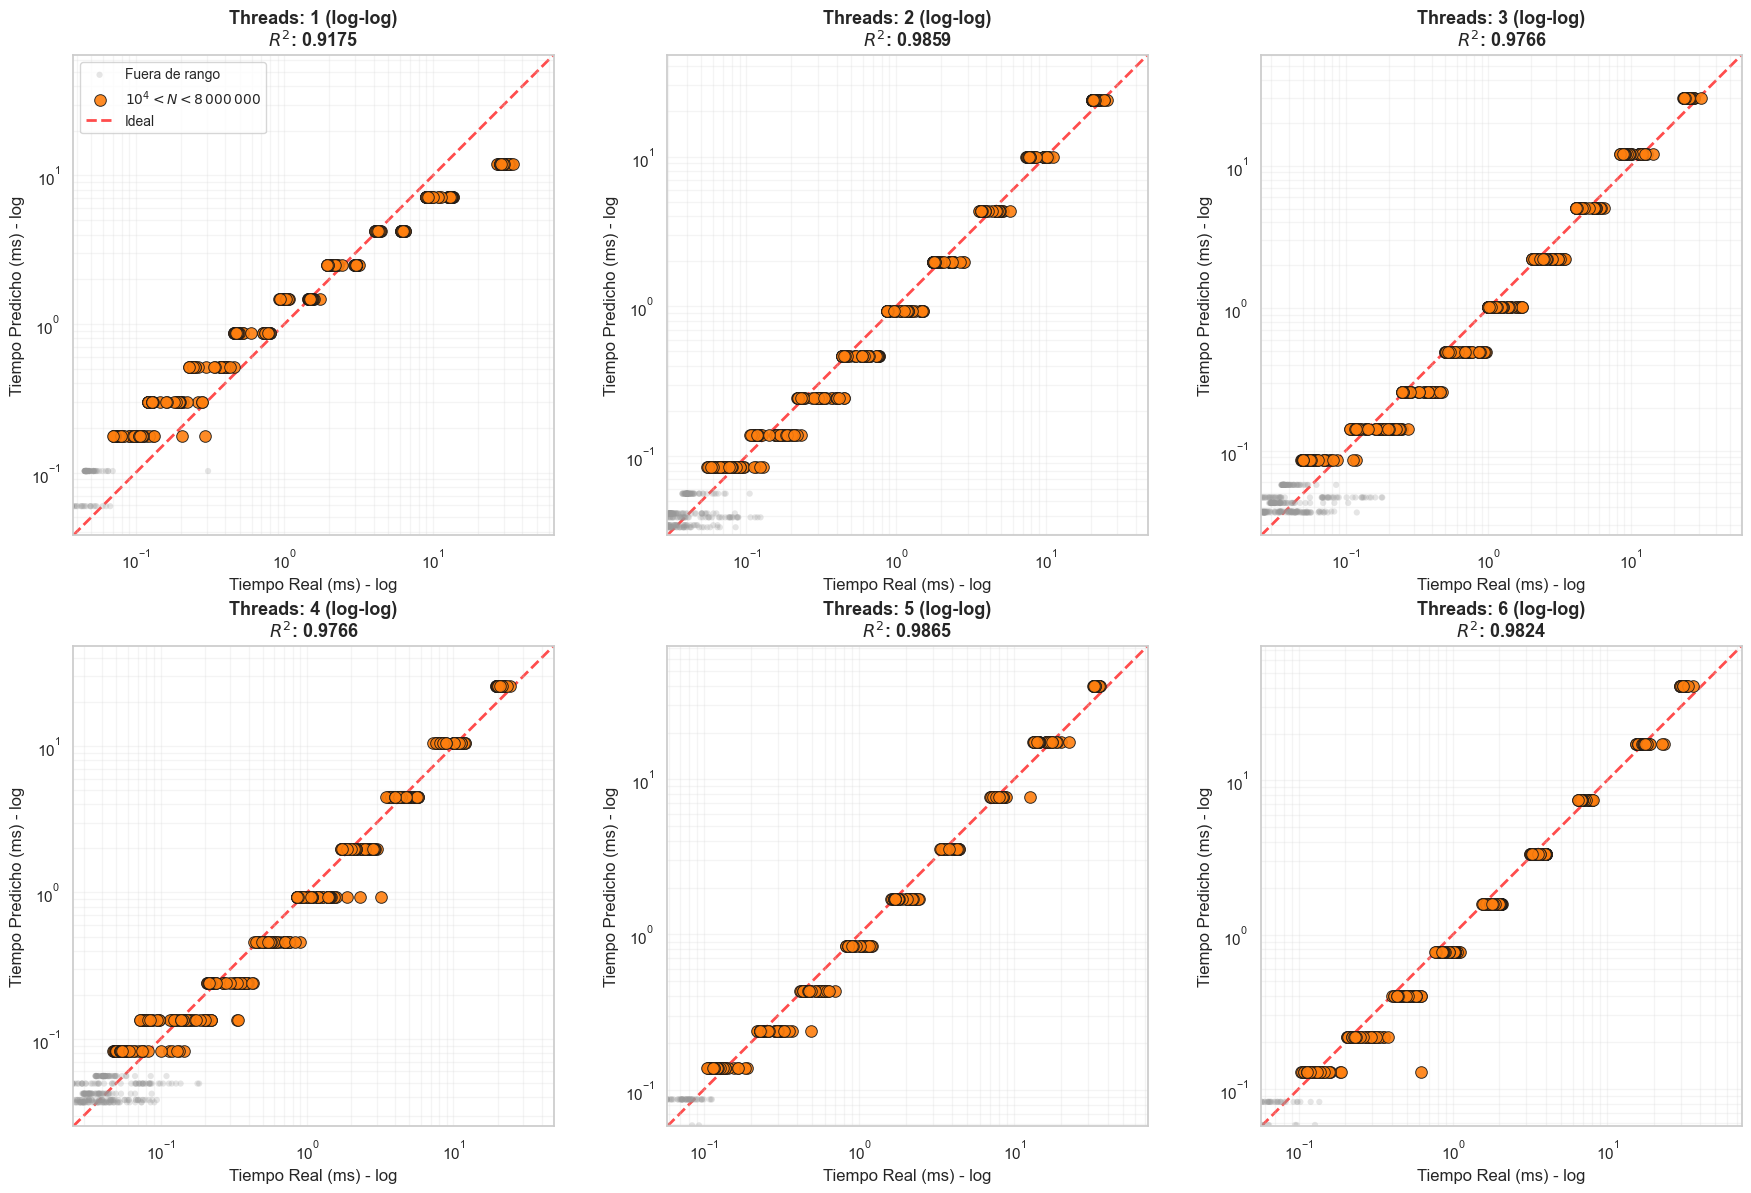

In [91]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def ejecutar_regresiones_segmentadas_visual_final(df_granular, n_min_exclusive=10000, n_max_exclusive=8000000):
    """
    Ajusta un modelo OLS log-log por thread y compara Real vs Predicho.
    Modelo por thread (log-log): log10(TotalTime) ~ const + log10(X_sort) (+ log10(X_merge) si Threads>1).
    """
    # 1. Filtro base para ENTRENAMIENTO (Threads > 0 y N < 8_000_000)
    df_base = df_granular[(df_granular['Threads'] > 0) & (df_granular['InputSize'] < n_max_exclusive)].copy()

    threads_disponibles = sorted(df_base['Threads'].unique())
    n_threads = len(threads_disponibles)

    # Configuración de la grilla
    cols = 3
    rows = (n_threads + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    axes = axes.flatten()

    resumen_coefs = []

    print(f"Iniciando generación de gráficos para {n_threads} configuraciones de hilos...")

    for i, k_val in enumerate(threads_disponibles):
        # Datos para este hilo
        df_k = df_base[df_base['Threads'] == k_val].copy()

        # --- A. AJUSTE DEL MODELO (Usando TODOS los datos N<8M) ---
        n = df_k['InputSize']
        # Predictores teóricos
        df_k['X_sort'] = (n / k_val) * np.log2(n / k_val)
        # Evitar log2(1)=0 en la división si k=1, aunque el predictor se anula luego
        df_k['X_merge'] = (n / k_val) * np.log2(k_val) if k_val > 1 else np.zeros_like(n)

        y_real_full = df_k['TotalTime']

        # Selección de predictores (evitamos X_merge si k=1)
        predictores = ['X_sort', 'X_merge'] if k_val > 1 else ['X_sort']

        # Preparación log-log (requiere positivos)
        df_model = df_k[predictores + ['TotalTime']].copy()
        pos_mask = (df_model['TotalTime'] > 0)
        for p in predictores:
            pos_mask &= (df_model[p] > 0)
        df_model = df_model[pos_mask].copy()
        if df_model.empty:
            print(f"  - Threads {k_val}: sin datos positivos para ajuste log-log")
            # Igual mostramos subplot vacío
            ax = axes[i]
            ax.text(0.5, 0.5, "Sin datos válidos para log-log", ha='center', va='center', transform=ax.transAxes)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.axis('off')
            continue

        y_log = np.log10(df_model['TotalTime'])
        X_log = np.log10(df_model[predictores])
        X_log = sm.add_constant(X_log, has_constant='add')

        # Ajuste OLS en log-espacio y predicción para TODO el thread
        res = sm.OLS(y_log, X_log).fit()

        X_all = df_k[predictores].copy()
        for p in predictores:
            X_all.loc[X_all[p] <= 0, p] = np.nan
        X_all_log = np.log10(X_all)
        X_all_log = sm.add_constant(X_all_log, has_constant='add')
        y_pred_log_full = res.predict(X_all_log)
        y_pred_full = (10 ** y_pred_log_full).astype(float)

        # Guardar estadísticas del modelo completo
        resumen_coefs.append({'Threads': k_val, 'R2': res.rsquared, **res.params.to_dict()})

        # --- B. VISUALIZACIÓN (destacando 10^4 < N < 8_000_000 con color) ---
        ax = axes[i]

        # Máscara para "lo que se quiere mirar"
        mask_hi = (df_k['InputSize'] > n_min_exclusive) & (df_k['InputSize'] < n_max_exclusive)
        mask_lo = ~mask_hi

        y_real_hi = y_real_full[mask_hi]
        y_pred_hi = y_pred_full[mask_hi]
        y_real_lo = y_real_full[mask_lo]
        y_pred_lo = y_pred_full[mask_lo]

        n_hi = int(mask_hi.sum())
        n_lo = int(mask_lo.sum())
        print(f"  - Threads {k_val}: {n_hi} puntos (10^4 < N < 8M) | {n_lo} puntos (fuera de rango)")

        # 1) Scatter: primero fuera de rango (apagado), luego en rango (destacado)
        if n_lo > 0:
            ax.scatter(
                y_real_lo,
                y_pred_lo,
                alpha=0.25,
                s=20,
                color='0.6',
                edgecolors='none',
                zorder=1,
                label='Fuera de rango' if i == 0 else None,
            )
        if n_hi > 0:
            ax.scatter(
                y_real_hi,
                y_pred_hi,
                alpha=0.9,
                s=70,
                color='tab:orange',
                edgecolors='k',
                linewidth=0.7,
                zorder=2,
                label=r'$10^4 < N < 8\,000\,000$' if i == 0 else None,
            )
        if n_hi == 0 and n_lo == 0:
            ax.text(0.5, 0.5, "Sin datos", ha='center', va='center', transform=ax.transAxes)

        # 2. Configurar escalas ANTES de calcular límites
        ax.set_xscale('log')
        ax.set_yscale('log')

        # 3. Límites robustos en espacio log (priorizando el rango si existe)
        if n_hi > 0:
            y_real_for_limits = y_real_hi
            y_pred_for_limits = y_pred_hi
        else:
            y_real_for_limits = y_real_lo
            y_pred_for_limits = y_pred_lo

        y_real_pos = y_real_for_limits[y_real_for_limits > 0]
        y_pred_pos = y_pred_for_limits[y_pred_for_limits > 0]
        y_pred_pos = y_pred_pos[np.isfinite(y_pred_pos)]

        if len(y_real_pos) > 0 and len(y_pred_pos) > 0:
            log_real = np.log10(y_real_pos)
            log_pred = np.log10(y_pred_pos)

            log_min = float(min(log_real.min(), log_pred.min()))
            log_max = float(max(log_real.max(), log_pred.max()))

            log_span = log_max - log_min
            if log_span < 0.5:
                log_span = 0.5
            pad = 0.1 * log_span
            final_log_min = log_min - pad
            final_log_max = log_max + pad
            min_val = 10**final_log_min
            max_val = 10**final_log_max
            ax.set_xlim(min_val, max_val)
            ax.set_ylim(min_val, max_val)

            # Línea de identidad perfecta
            ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, alpha=0.7, zorder=0, label='Ideal' if i == 0 else None)

        # 4. Forzar aspecto cuadrado al final
        ax.set_aspect('equal', adjustable='box')

        # Títulos y etiquetas usando estadísticas del modelo COMPLETO
        ax.set_title(f"Threads: {k_val} (log-log)\n$R^2$: {res.rsquared:.4f}", fontsize=13, fontweight='bold')
        ax.set_xlabel("Tiempo Real (ms) - log")
        ax.set_ylabel("Tiempo Predicho (ms) - log")
        ax.grid(True, which="both", ls="-", alpha=0.2)
        if i == 0:
            ax.legend(loc='upper left', fontsize='small')

    # Limpieza de subplots sobrantes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    print()
    return pd.DataFrame(resumen_coefs)

# Ejecución
df_coefs_final = ejecutar_regresiones_segmentadas_visual_final(df_granular)

<>:67: SyntaxWarning: invalid escape sequence '\,'
<>:85: SyntaxWarning: invalid escape sequence '\,'
<>:67: SyntaxWarning: invalid escape sequence '\,'
<>:85: SyntaxWarning: invalid escape sequence '\,'
C:\TempPath\Temp\ipykernel_27516\1255336334.py:67: SyntaxWarning: invalid escape sequence '\,'
  ax.text(0.5, 0.5, f"Sin datos para $10^4 < N < 8\,000\,000$\n(Threads={int(k_val)})", ha='center', va='center', transform=ax.transAxes)
C:\TempPath\Temp\ipykernel_27516\1255336334.py:85: SyntaxWarning: invalid escape sequence '\,'
  f"$10^4 < N < 8\,000\,000$: {n_plot} pts | $R^2$: {res.rsquared:.4f}"


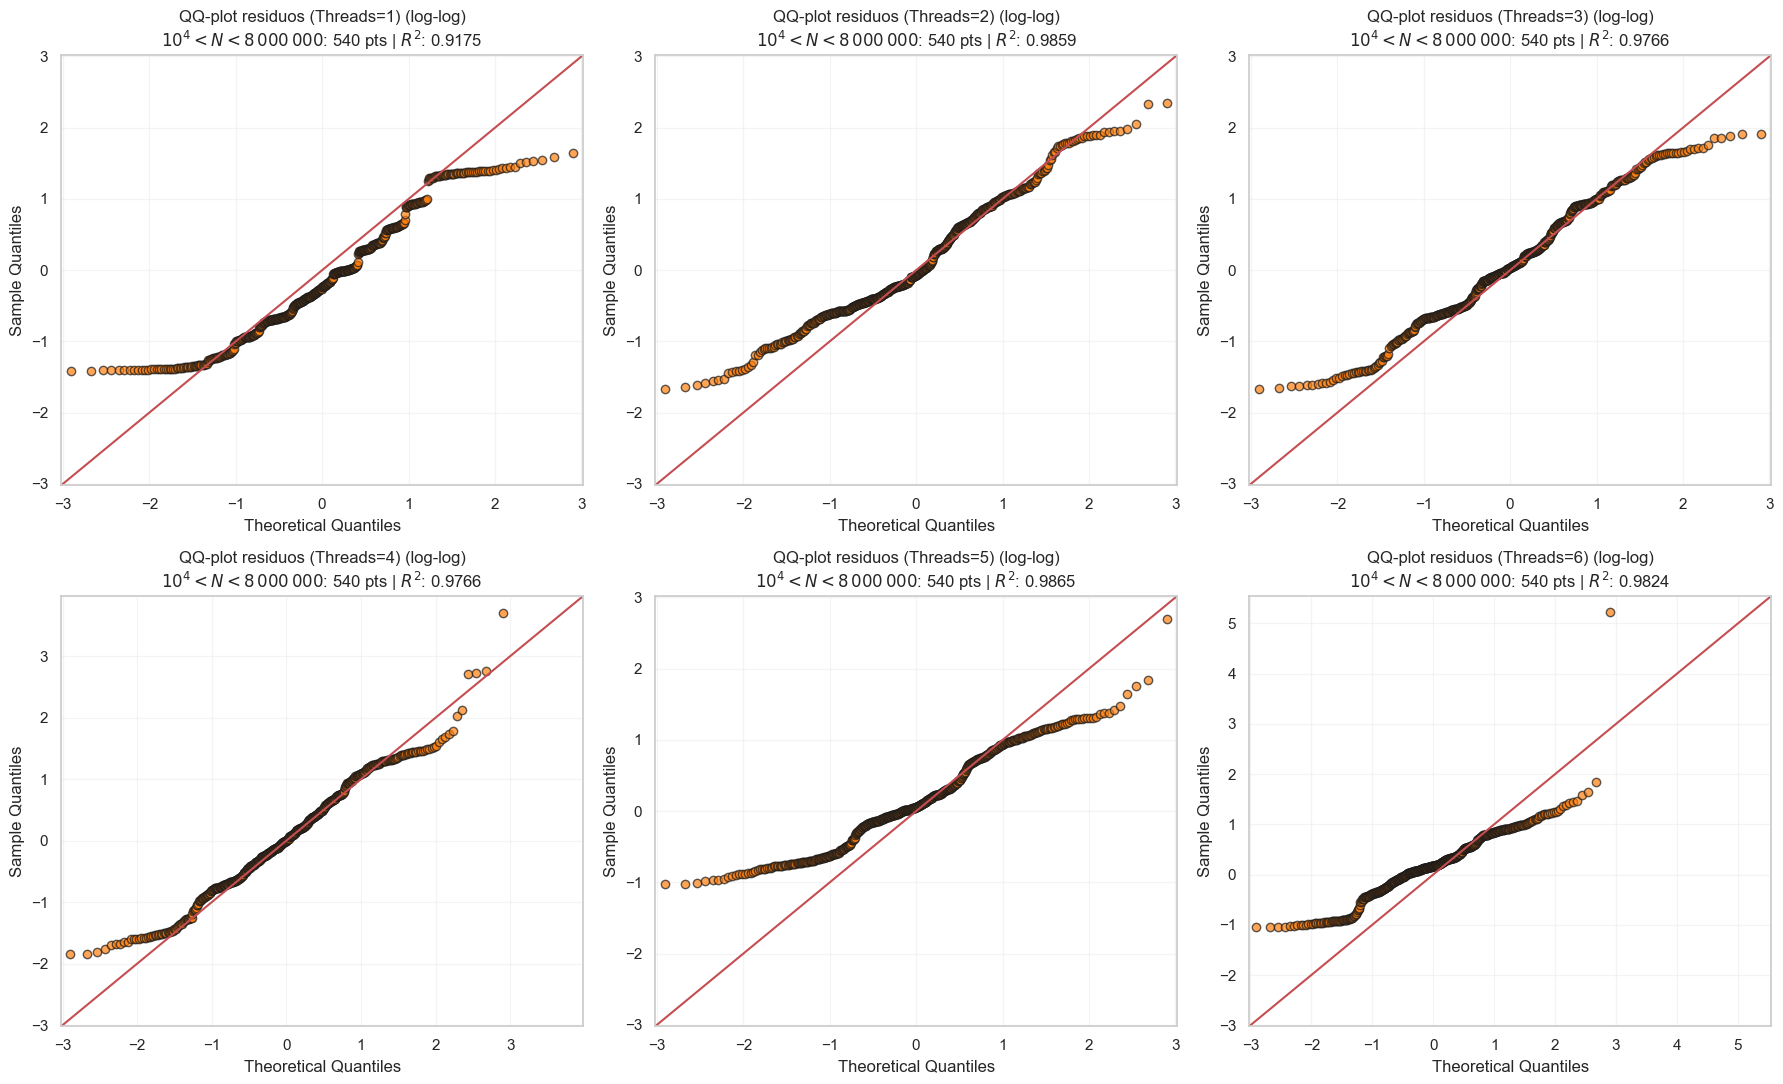

In [92]:
# QQ-plot de residuos por Threads (normalidad) para el modelo log-log, filtrando: 10^4 < N < 8_000_000
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

def qqplot_residuos_por_thread(df_granular, n_min_exclusive=10000, n_max_exclusive=8000000):
    """
    Ajusta el mismo modelo OLS log-log por thread y grafica QQ-plot de residuos studentizados
    usando SOLO los puntos que se visualizan en el scatter: 10^4 < N < 8_000_000.

    Modelo por thread (log-log): log10(TotalTime) ~ const + log10(X_sort) (+ log10(X_merge) si Threads>1).
    """
    if df_granular is None or getattr(df_granular, 'empty', True):
        print("Saltando QQ-plot: df_granular no está cargado o está vacío.")
        return

    # Filtro base: Threads>0 y N<8M
    df_base = df_granular[(df_granular['Threads'] > 0) & (df_granular['InputSize'] < n_max_exclusive)].copy()
    threads_disponibles = sorted(df_base['Threads'].dropna().unique())
    if len(threads_disponibles) == 0:
        print("Saltando QQ-plot: no hay threads disponibles tras el filtro.")
        return

    cols = 3
    rows = (len(threads_disponibles) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5.5 * rows))
    axes = np.array(axes).flatten()

    for i, k_val in enumerate(threads_disponibles):
        df_k = df_base[df_base['Threads'] == k_val].copy()
        ax = axes[i]
        if df_k.empty:
            ax.axis('off')
            continue

        # Predictores teóricos
        n = df_k['InputSize']
        df_k['X_sort'] = (n / k_val) * np.log2(n / k_val)
        df_k['X_merge'] = (n / k_val) * np.log2(k_val) if k_val > 1 else np.zeros_like(n)

        y = df_k['TotalTime']
        predictores = ['X_sort', 'X_merge'] if k_val > 1 else ['X_sort']

        # Datos válidos para log-log (positivos)
        df_model = df_k[predictores + ['TotalTime', 'InputSize']].copy()
        pos_mask = (df_model['TotalTime'] > 0)
        for p in predictores:
            pos_mask &= (df_model[p] > 0)
        df_model = df_model[pos_mask].copy()
        if df_model.empty:
            ax.text(0.5, 0.5, f"Sin datos positivos\n(Threads={int(k_val)})", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Threads: {int(k_val)}")
            ax.axis('off')
            continue

        # Ajuste log-log usando TODOS los datos válidos del thread (N<8M)
        y_log = np.log10(df_model['TotalTime'])
        X_log = np.log10(df_model[predictores])
        X_log = sm.add_constant(X_log, has_constant='add')
        res = sm.OLS(y_log, X_log).fit()

        # Filtrado igual que el scatter: 10^4 < N < 8_000_000
        mask_plot = (df_model['InputSize'] > n_min_exclusive) & (df_model['InputSize'] < n_max_exclusive)
        n_plot = int(mask_plot.sum())
        if n_plot == 0:
            ax.text(0.5, 0.5, f"Sin datos para $10^4 < N < 8\,000\,000$\n(Threads={int(k_val)})", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Threads: {int(k_val)}")
            ax.axis('off')
            continue

        # Residuos studentizados (en el espacio log) y filtrado por máscara
        infl = res.get_influence()
        resid = pd.Series(infl.resid_studentized_internal, index=df_model.index)
        resid = resid[mask_plot].replace([np.inf, -np.inf], np.nan).dropna()
        if resid.empty:
            ax.text(0.5, 0.5, "Sin residuos válidos", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Threads: {int(k_val)}")
            ax.axis('off')
            continue

        sm.qqplot(resid, line='45', ax=ax, markerfacecolor='tab:orange', markeredgecolor='k', alpha=0.7)
        ax.set_title(
            f"QQ-plot residuos (Threads={int(k_val)}) (log-log)\n"
            f"$10^4 < N < 8\,000\,000$: {n_plot} pts | $R^2$: {res.rsquared:.4f}"
        )
        ax.grid(True, alpha=0.2)

    # Limpiar subplots sobrantes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Ejecutar QQ-plots
qqplot_residuos_por_thread(df_granular)

In [93]:
import statsmodels.formula.api as smf

def wls_regresion_por_thread(df_granular):
    # Filtro igual al scatter
    df_base = df_granular[(df_granular['Threads'] > 0) &
                           (df_granular['InputSize'] > 10000) &
                           (df_granular['InputSize'] < 8000000)].copy()

    threads = sorted(df_base['Threads'].unique())

    for k_val in threads:
        df_k = df_base[df_base['Threads'] == k_val].copy()

        # Predictores directos (Lineales)
        n = df_k['InputSize']
        df_k['X1'] = (n / k_val) * np.log2(n / k_val)
        df_k['X2'] = (n / k_val) * np.log2(k_val) if k_val > 1 else 0

        # Definimos pesos para corregir heterocedasticidad: peso = 1/N
        weights = 1.0 / (df_k['InputSize'])

        # Modelo WLS (Weighted Least Squares)
        if k_val > 1:
            model = sm.WLS(df_k['TotalTime'], sm.add_constant(df_k[['X1', 'X2']]), weights=weights)
        else:
            model = sm.WLS(df_k['TotalTime'], sm.add_constant(df_k[['X1']]), weights=weights)

        res = model.fit()

        print(f"Threads {k_val} - R2: {res.rsquared:.4f}")
        # Aquí podrías graficar el QQ-plot de este nuevo modelo

#graficar

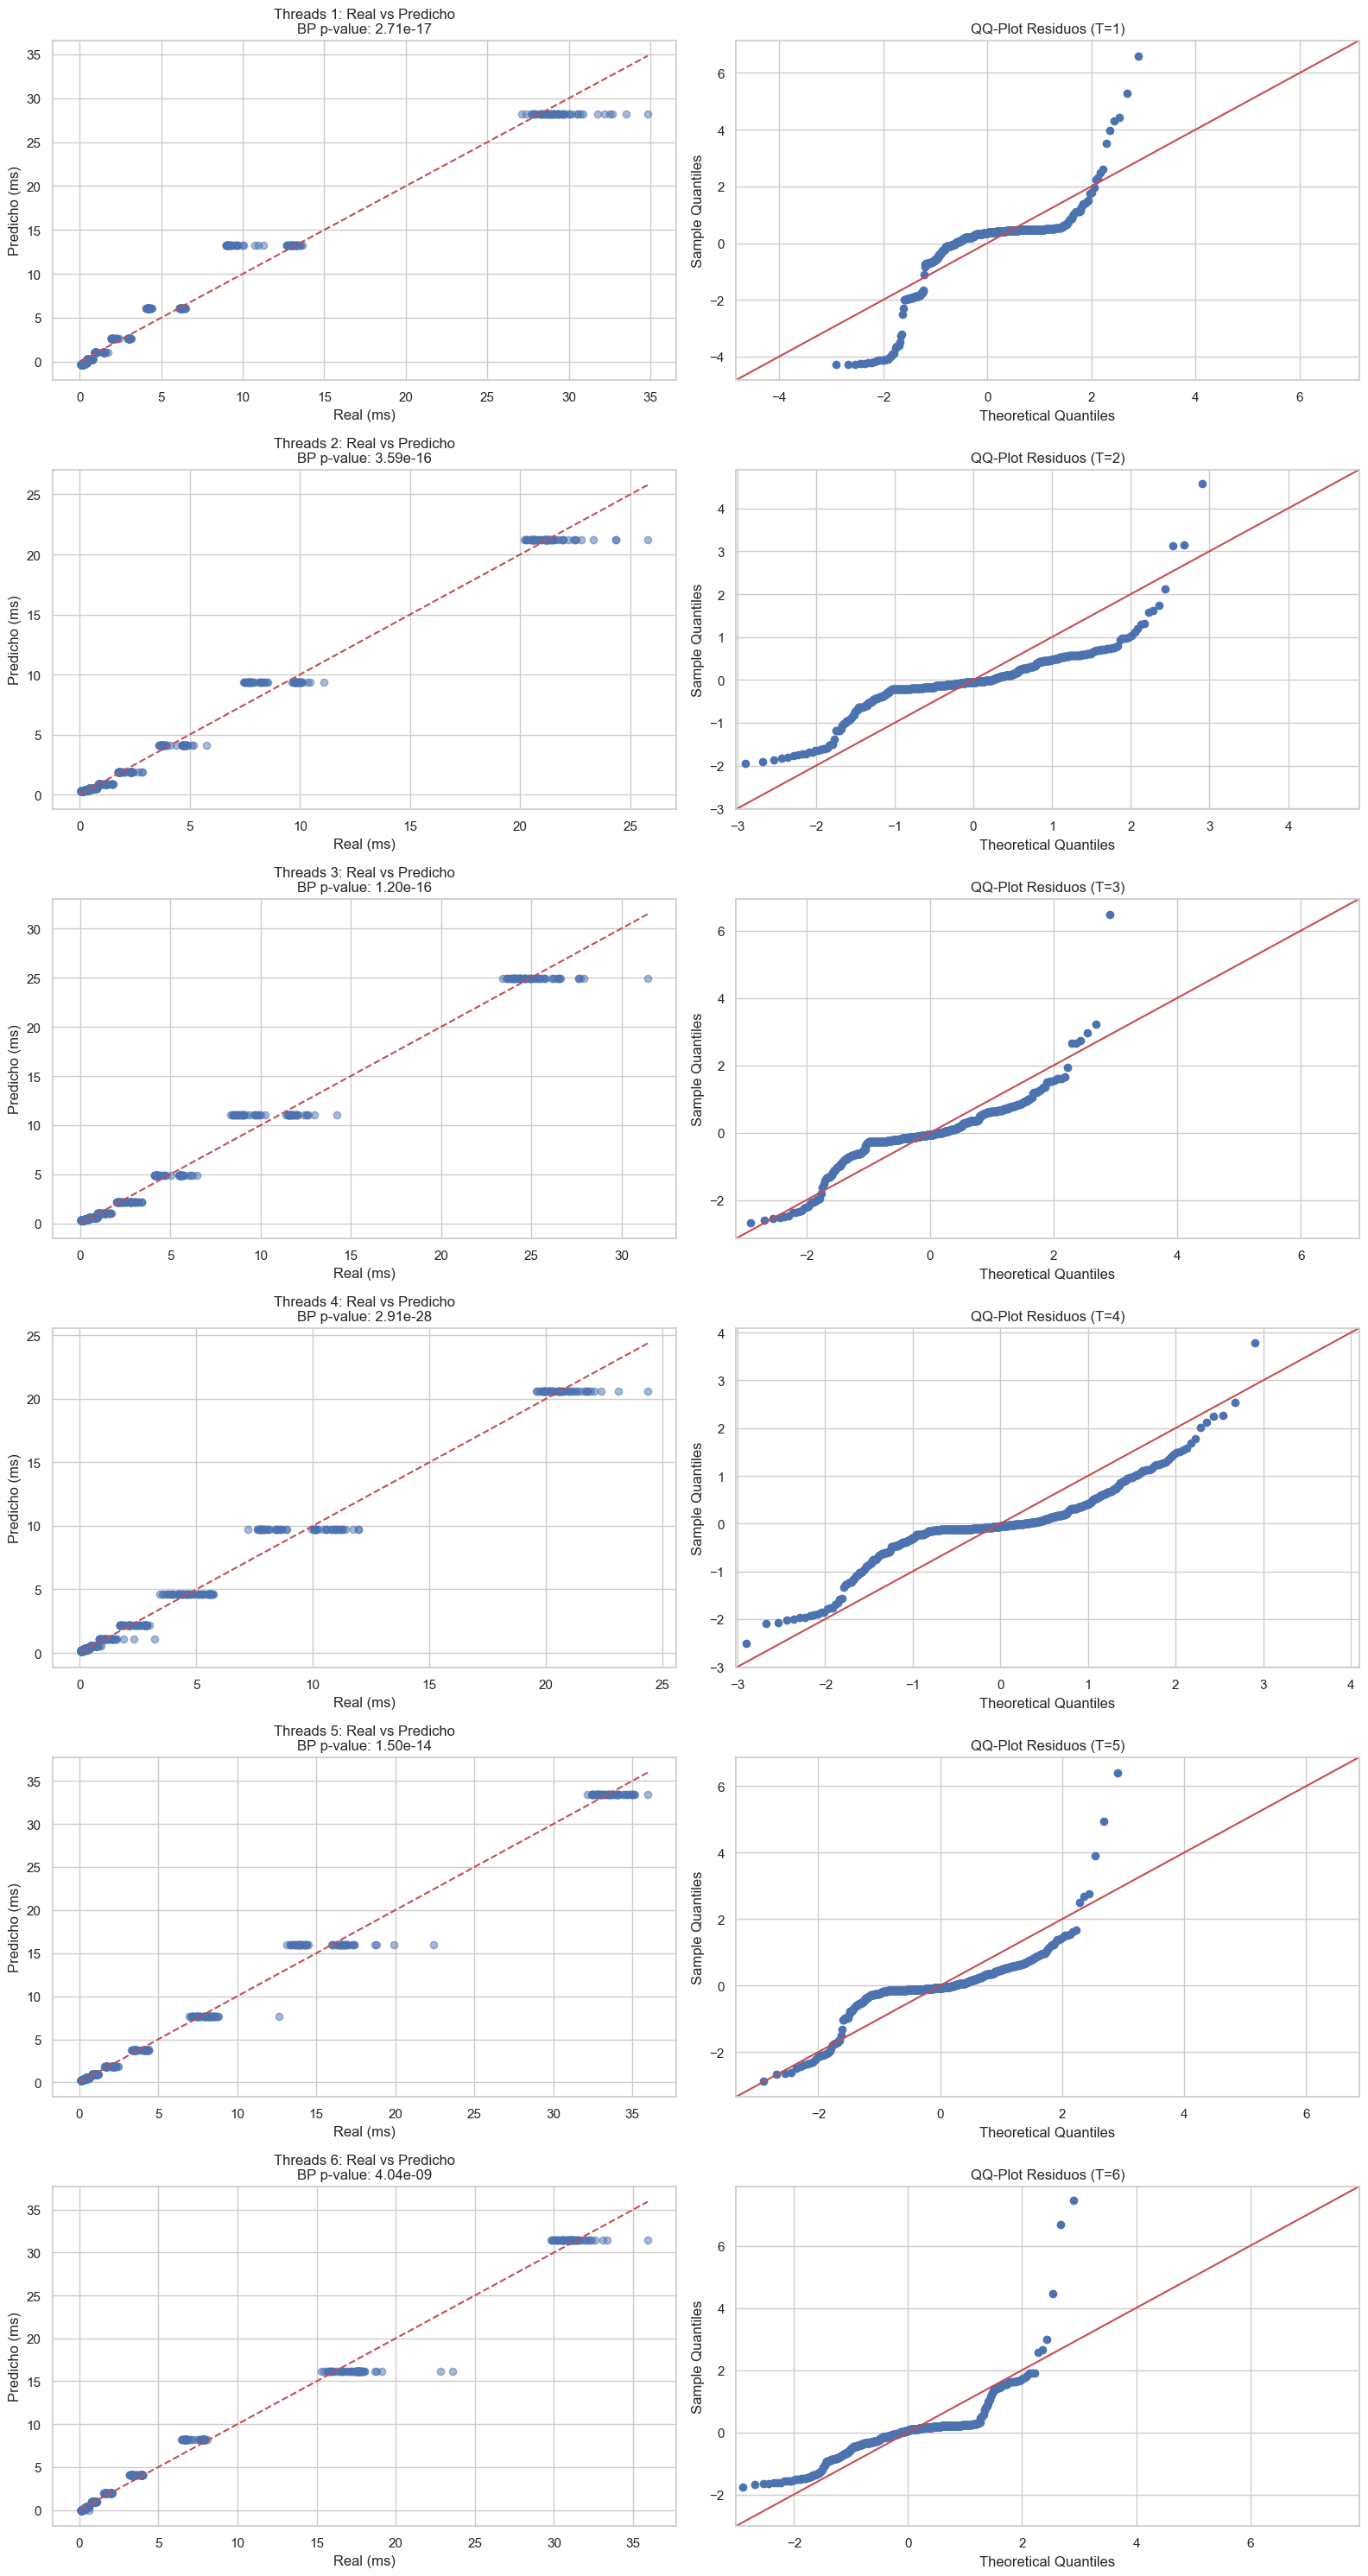

In [94]:
from statsmodels.stats.diagnostic import het_breuschpagan

def analisis_riguroso_heterocedasticidad(df_granular):
    # 1. Filtro estricto solicitado: 10^4 < n < 8.000.000
    df = df_granular[(df_granular['Threads'] > 0) &
                     (df_granular['InputSize'] > 10000) &
                     (df_granular['InputSize'] < 8000000)].copy()

    threads = sorted(df['Threads'].unique())
    fig, axes = plt.subplots(len(threads), 2, figsize=(16, 5 * len(threads)))

    resultados_test = []

    for i, k in enumerate(threads):
        df_k = df[df['Threads'] == k].copy()
        n = df_k['InputSize']

        # Predictores del modelo M4 (Lineales)
        df_k['X_sort'] = (n / k) * np.log2(n / k)
        df_k['X_merge'] = (n / k) * np.log2(k) if k > 1 else 0

        y = df_k['TotalTime']
        predictores = ['X_sort', 'X_merge'] if k > 1 else ['X_sort']
        X = sm.add_constant(df_k[predictores])

        # Ajuste OLS
        res = sm.OLS(y, X).fit()

        # --- PRUEBA DE BREUSCH-PAGAN ---
        _, p_value, _, _ = het_breuschpagan(res.resid, X)

        # --- GRÁFICO 1: Real vs Predicho (Escala Lineal) ---
        ax_reg = axes[i, 0]
        y_pred = res.predict(X)
        ax_reg.scatter(y, y_pred, alpha=0.5, label=f'T={k}')
        ax_reg.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
        ax_reg.set_title(f"Threads {k}: Real vs Predicho\nBP p-value: {p_value:.2e}")
        ax_reg.set_xlabel("Real (ms)")
        ax_reg.set_ylabel("Predicho (ms)")

        # --- GRÁFICO 2: QQ-Plot de Residuos ---
        ax_qq = axes[i, 1]
        sm.qqplot(res.resid, line='45', ax=ax_qq)
        ax_qq.set_title(f"QQ-Plot Residuos (T={k})")

        resultados_test.append({'Threads': k, 'BP_p_value': p_value, 'R2': res.rsquared})

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(resultados_test)

# Ejecución
df_bp = analisis_riguroso_heterocedasticidad(df_granular)

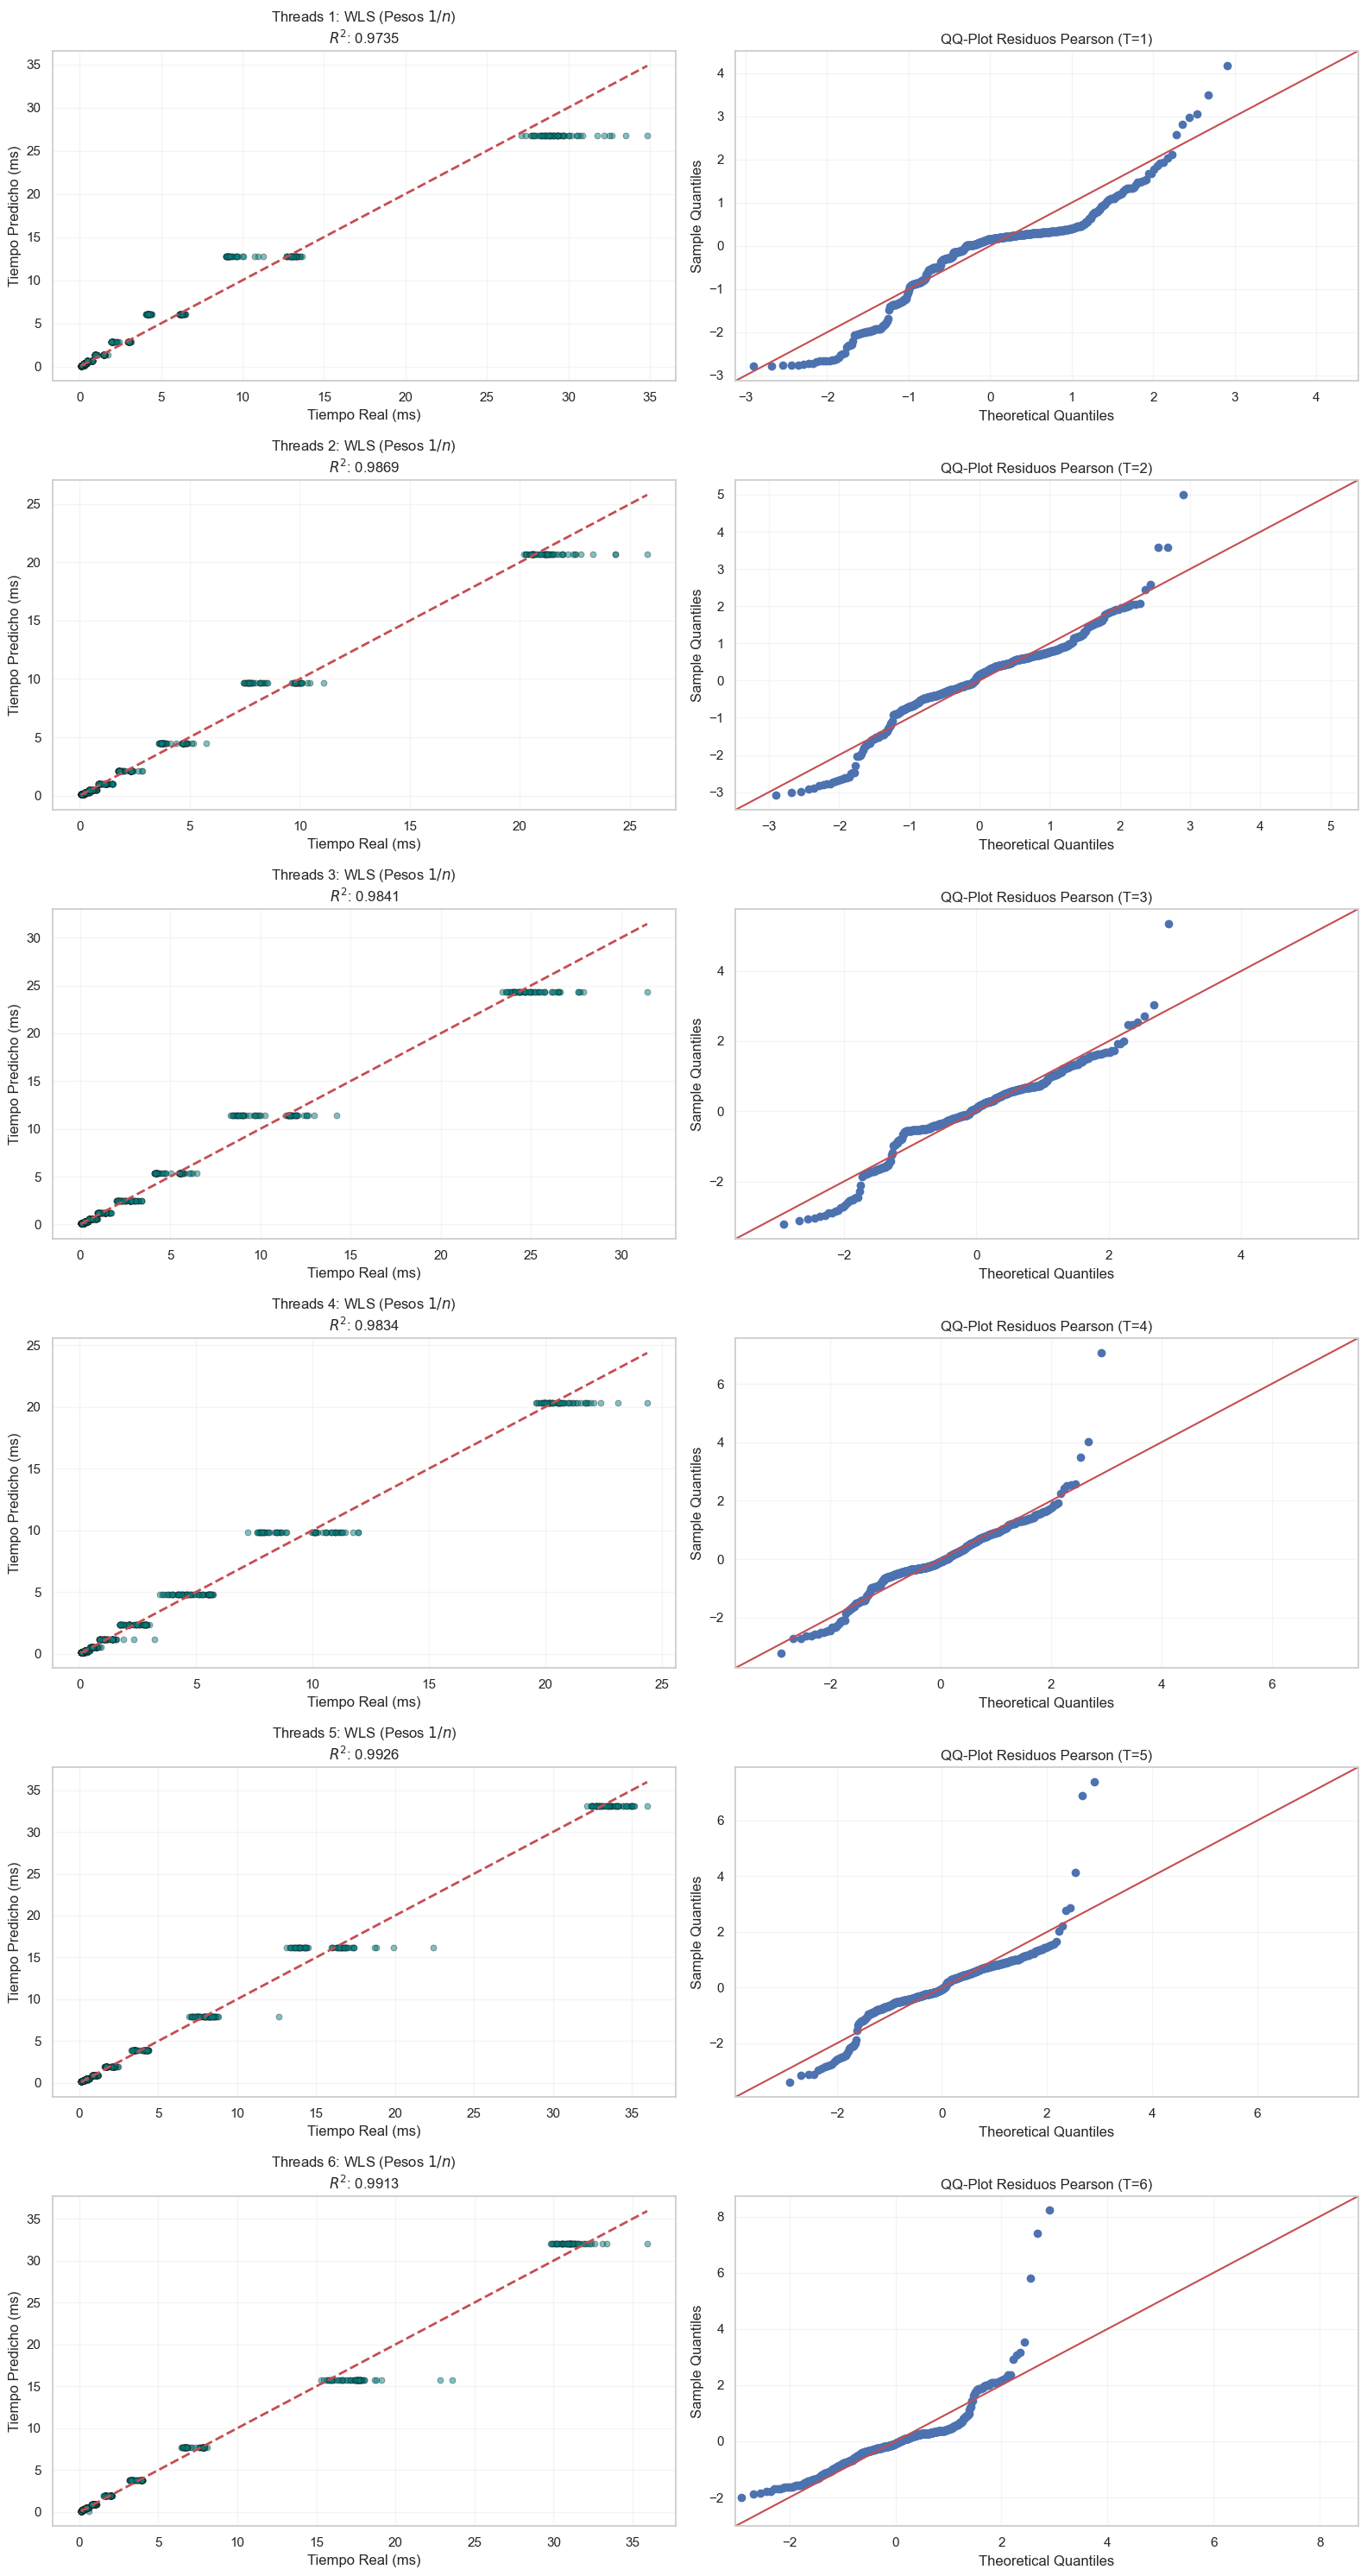

In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def ejecutar_regresion_wls_final(df_granular):
    # 1. Filtro estricto: 10^4 < n < 8.000.000
    df = df_granular[(df_granular['Threads'] > 0) &
                     (df_granular['InputSize'] > 10000) &
                     (df_granular['InputSize'] < 8000000)].copy()

    threads = sorted(df['Threads'].unique())
    fig, axes = plt.subplots(len(threads), 2, figsize=(16, 5 * len(threads)))

    # Asegurar que axes sea bidimensional incluso con un solo thread
    if len(threads) == 1:
        axes = axes.reshape(1, 2)

    resultados_wls = []

    for i, k in enumerate(threads):
        df_k = df[df['Threads'] == k].copy()
        n = df_k['InputSize']

        # Predictores teóricos
        df_k['X_sort'] = (n / k) * np.log2(n / k)
        df_k['X_merge'] = (n / k) * np.log2(k) if k > 1 else 0

        y = df_k['TotalTime']
        predictores = ['X_sort', 'X_merge'] if k > 1 else ['X_sort']
        X = sm.add_constant(df_k[predictores])

        # --- PESOS: 1/n para corregir la heterocedasticidad ---
        weights = 1.0 / n

        # Ajuste WLS
        res_wls = sm.WLS(y, X, weights=weights).fit()

        # --- DIAGNÓSTICO ---
        # En WLS usamos resid_pearson, que son los residuos ya normalizados por los pesos
        residuos_a_graficar = res_wls.resid_pearson

        # --- GRÁFICO 1: Real vs Predicho ---
        ax_reg = axes[i, 0]
        y_pred = res_wls.predict(X)
        ax_reg.scatter(y, y_pred, alpha=0.5, color='teal', s=25, edgecolors='k', linewidth=0.5)
        ax_reg.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        ax_reg.set_title(f"Threads {k}: WLS (Pesos $1/n$)\n$R^2$: {res_wls.rsquared:.4f}")
        ax_reg.set_xlabel("Tiempo Real (ms)")
        ax_reg.set_ylabel("Tiempo Predicho (ms)")
        ax_reg.grid(True, alpha=0.2)

        # --- GRÁFICO 2: QQ-Plot de Residuos de Pearson ---
        ax_qq = axes[i, 1]
        sm.qqplot(residuos_a_graficar, line='45', ax=ax_qq)
        ax_qq.set_title(f"QQ-Plot Residuos Pearson (T={k})")
        ax_qq.grid(True, alpha=0.2)

        resultados_wls.append({'Threads': k, 'R2': res_wls.rsquared, 'params': res_wls.params})

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(resultados_wls)

# Ejecución
df_res_wls = ejecutar_regresion_wls_final(df_granular)

In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calcular_vif_modelo_completo(df_granular):
    df = df_granular[df_granular['Threads'] > 0].copy()
    n = df['InputSize']
    k = df['Threads']
    
    # Construimos la matriz de diseño teórica
    df_vif = pd.DataFrame({
        'const': 1,
        'Sort': (n / k) * np.log2(n / k),
        'Pivots': k * np.log2(k),
        'Run_Clasification': k*np.log2(n / k),
        'Prefix': k,
        'Merge': (n / k) * np.log2(k)
    })
    
    # Calculamos VIF por cada columna
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]
    
    return vif_data

print(calcular_vif_modelo_completo(df_granular))

            Variable        VIF
0              const  58.557169
1               Sort   1.441437
2             Pivots  92.011304
3  Run_Clasification   3.804259
4             Prefix  93.988183
5              Merge   1.933077


Analizando rango estricto: 10000 < N < 4200000


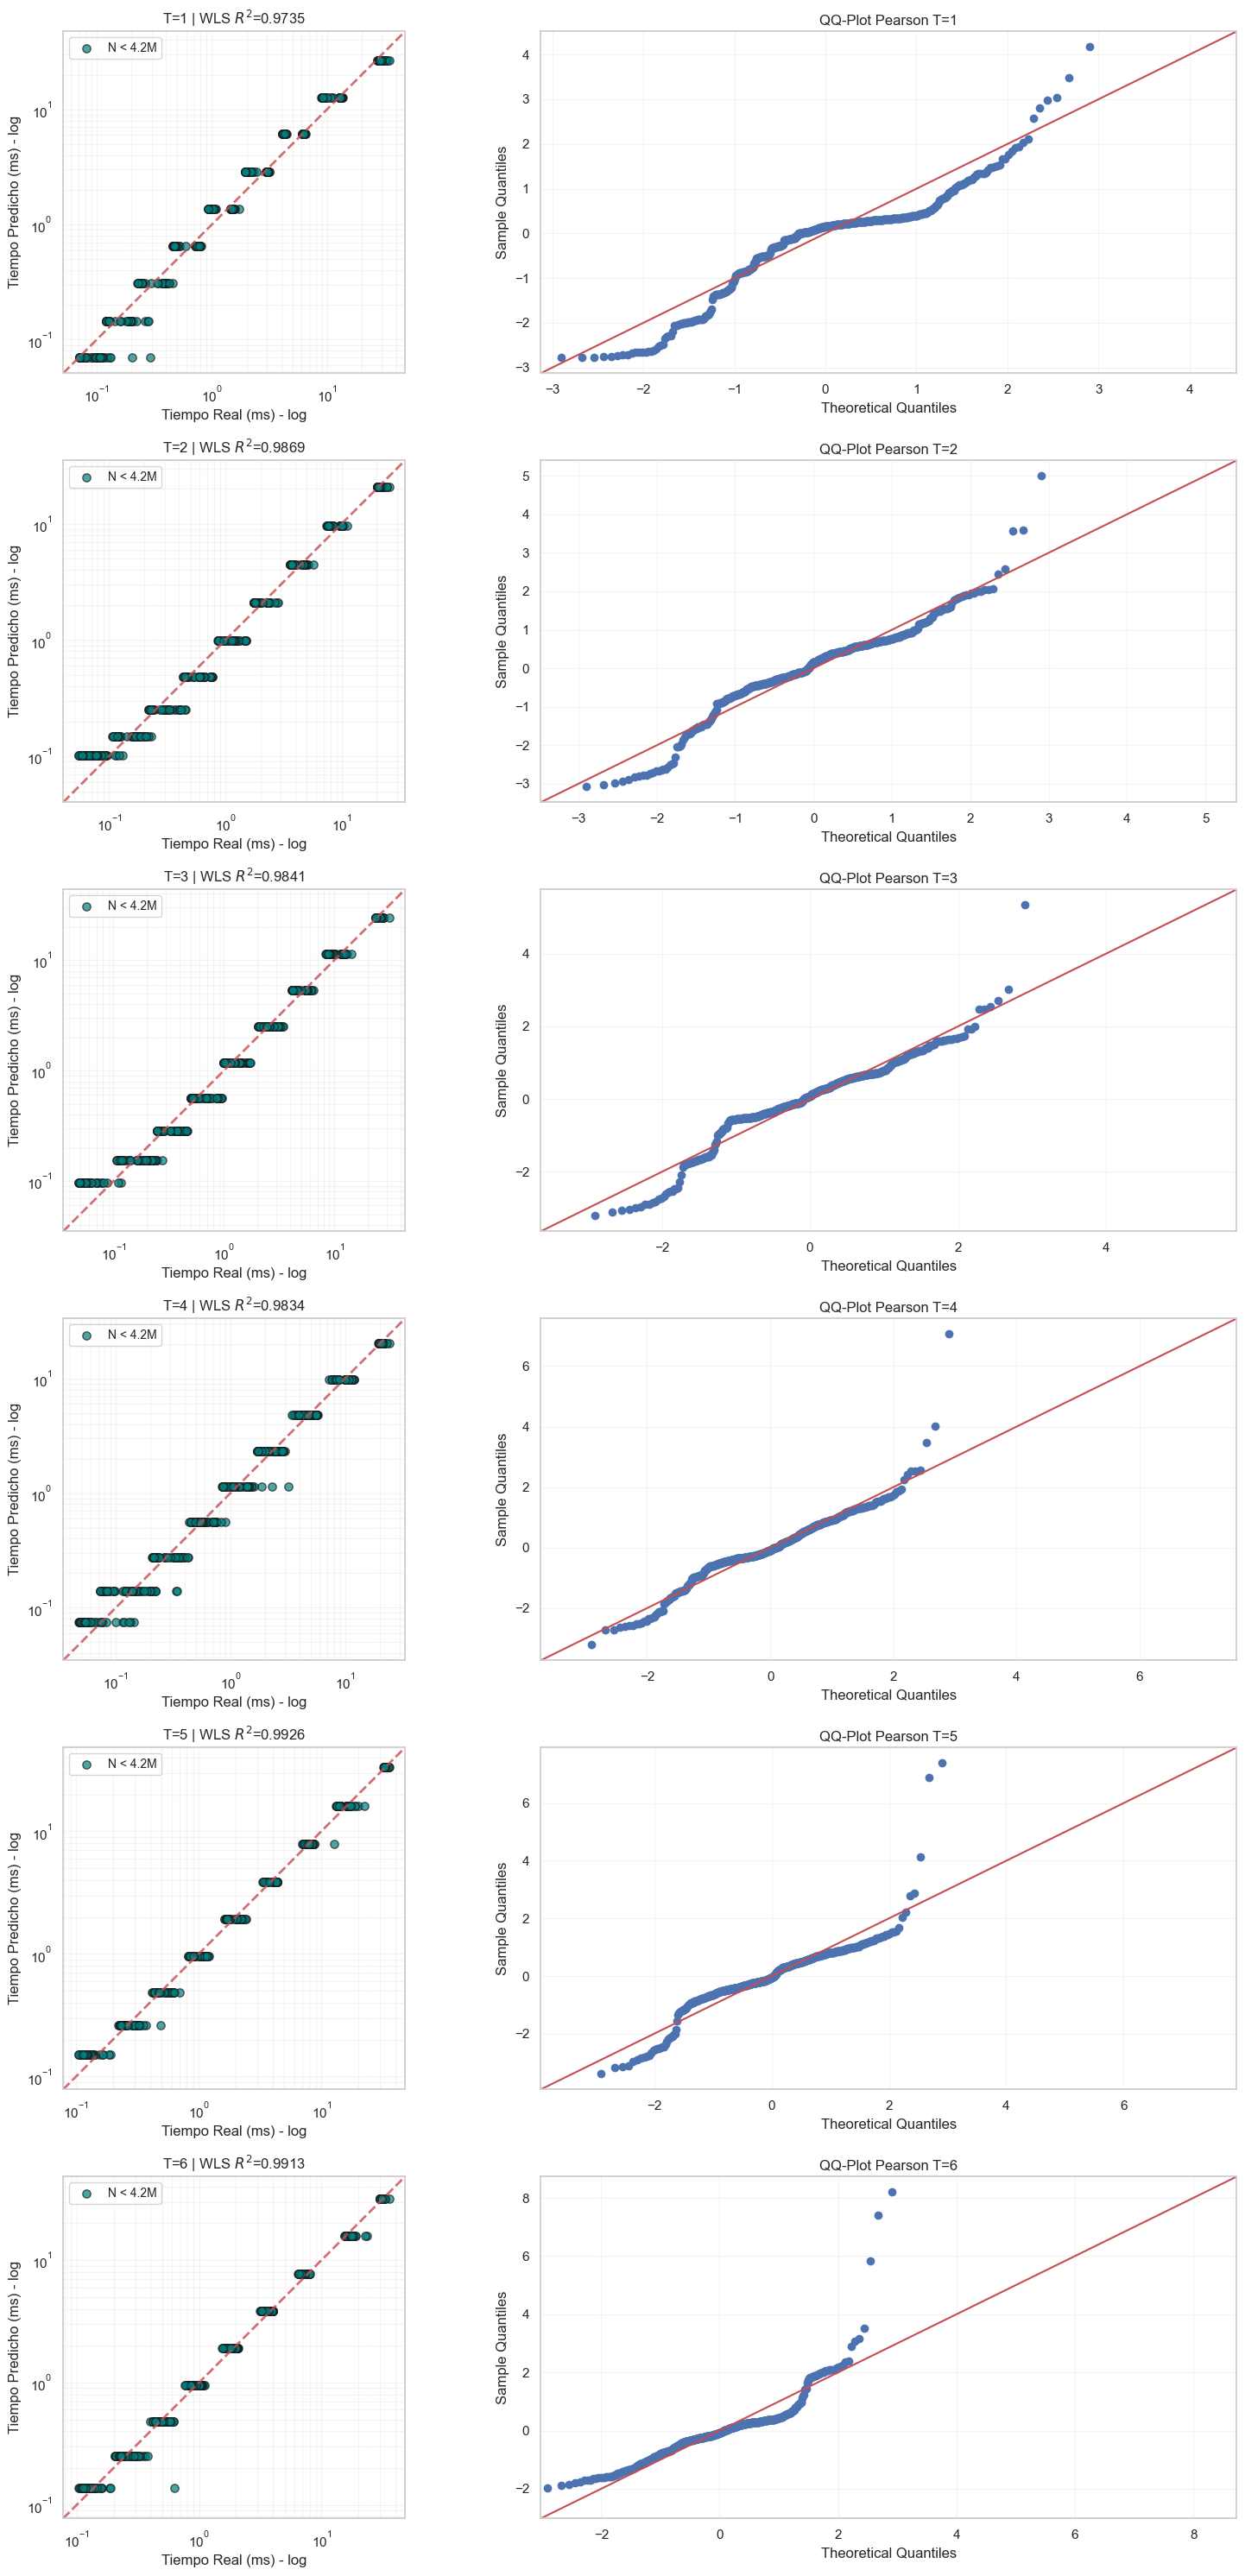

In [112]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def ejecutar_wls_filtro_estricto_log(df_granular):
    # --- NUEVO FILTRO MÁS ESTRICTO ---
    # Reducimos el límite superior de 8M a 4.2M (aprox 2^22)
    # para asegurar que estamos cómodamente dentro de la L3 sin saturación.
    LIMITE_INFERIOR = 10000
    LIMITE_SUPERIOR = 4200000

    df = df_granular[(df_granular['Threads'] > 0) &
                     (df_granular['InputSize'] > LIMITE_INFERIOR) &
                     (df_granular['InputSize'] < LIMITE_SUPERIOR)].copy()

    threads = sorted(df['Threads'].unique())

    # Verificar que quedan datos después del filtro
    if df.empty:
        print("Error: El filtro es demasiado estricto, no quedan datos.")
        return

    # Configuración de la grilla
    fig, axes = plt.subplots(len(threads), 2, figsize=(16, 5 * len(threads)))
    if len(threads) == 1:
        axes = axes.reshape(1, 2)

    resumen_modelos = []

    print(f"Analizando rango estricto: {LIMITE_INFERIOR} < N < {LIMITE_SUPERIOR}")

    for i, k in enumerate(threads):
        df_k = df[df['Threads'] == k].copy()

        if df_k.empty:
            continue

        n = df_k['InputSize']

        # Predictores del modelo WLS
        df_k['X_sort'] = (n / k) * np.log2(n / k)
        df_k['X_merge'] = (n / k) * np.log2(k) if k > 1 else 0

        y_real = df_k['TotalTime']
        predictores = ['X_sort', 'X_merge'] if k > 1 else ['X_sort']
        X = sm.add_constant(df_k[predictores])

        # PESOS: 1/n sigue siendo necesario
        weights = 1.0 / n

        # Ajuste WLS
        res_wls = sm.WLS(y_real, X, weights=weights).fit()
        y_pred = res_wls.predict(X)

        # --- VISUALIZACIÓN IZQUIERDA: Real vs Predicho (Log-Log) ---
        ax_reg = axes[i, 0]
        mask_pos = (y_real > 0) & (y_pred > 0)
        y_real_plot = y_real[mask_pos]
        y_pred_plot = y_pred[mask_pos]

        if len(y_real_plot) > 0:
            ax_reg.scatter(y_real_plot, y_pred_plot, alpha=0.7, color='teal', edgecolors='k', s=45, label=f'N < {LIMITE_SUPERIOR/1e6:.1f}M')

            # Escala y límites logarítmicos cuadrados
            ax_reg.set_xscale('log')
            ax_reg.set_yscale('log')

            log_min = np.log10(min(y_real_plot.min(), y_pred_plot.min()))
            log_max = np.log10(max(y_real_plot.max(), y_pred_plot.max()))
            pad = 0.05 * (log_max - log_min)

            limit_min = 10**(log_min - pad)
            limit_max = 10**(log_max + pad)

            ax_reg.set_xlim(limit_min, limit_max)
            ax_reg.set_ylim(limit_min, limit_max)
            ax_reg.plot([limit_min, limit_max], [limit_min, limit_max], 'r--', lw=2, alpha=0.8)
            ax_reg.set_aspect('equal', adjustable='box')

        ax_reg.set_title(f"T={k} | WLS $R^2$={res_wls.rsquared:.4f}")
        ax_reg.set_xlabel("Tiempo Real (ms) - log")
        ax_reg.set_ylabel("Tiempo Predicho (ms) - log")
        ax_reg.grid(True, which="both", ls="-", alpha=0.2)
        ax_reg.legend(loc='upper left', fontsize='small')

        # --- VISUALIZACIÓN DERECHA: QQ-Plot Pearson ---
        sm.qqplot(res_wls.resid_pearson, line='45', ax=axes[i, 1])
        axes[i, 1].set_title(f"QQ-Plot Pearson T={k}")
        axes[i, 1].grid(True, alpha=0.2)

        resumen_modelos.append({'Threads': k, 'R2': res_wls.rsquared})

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(resumen_modelos)

# Ejecución
df_final_strict = ejecutar_wls_filtro_estricto_log(df_granular)

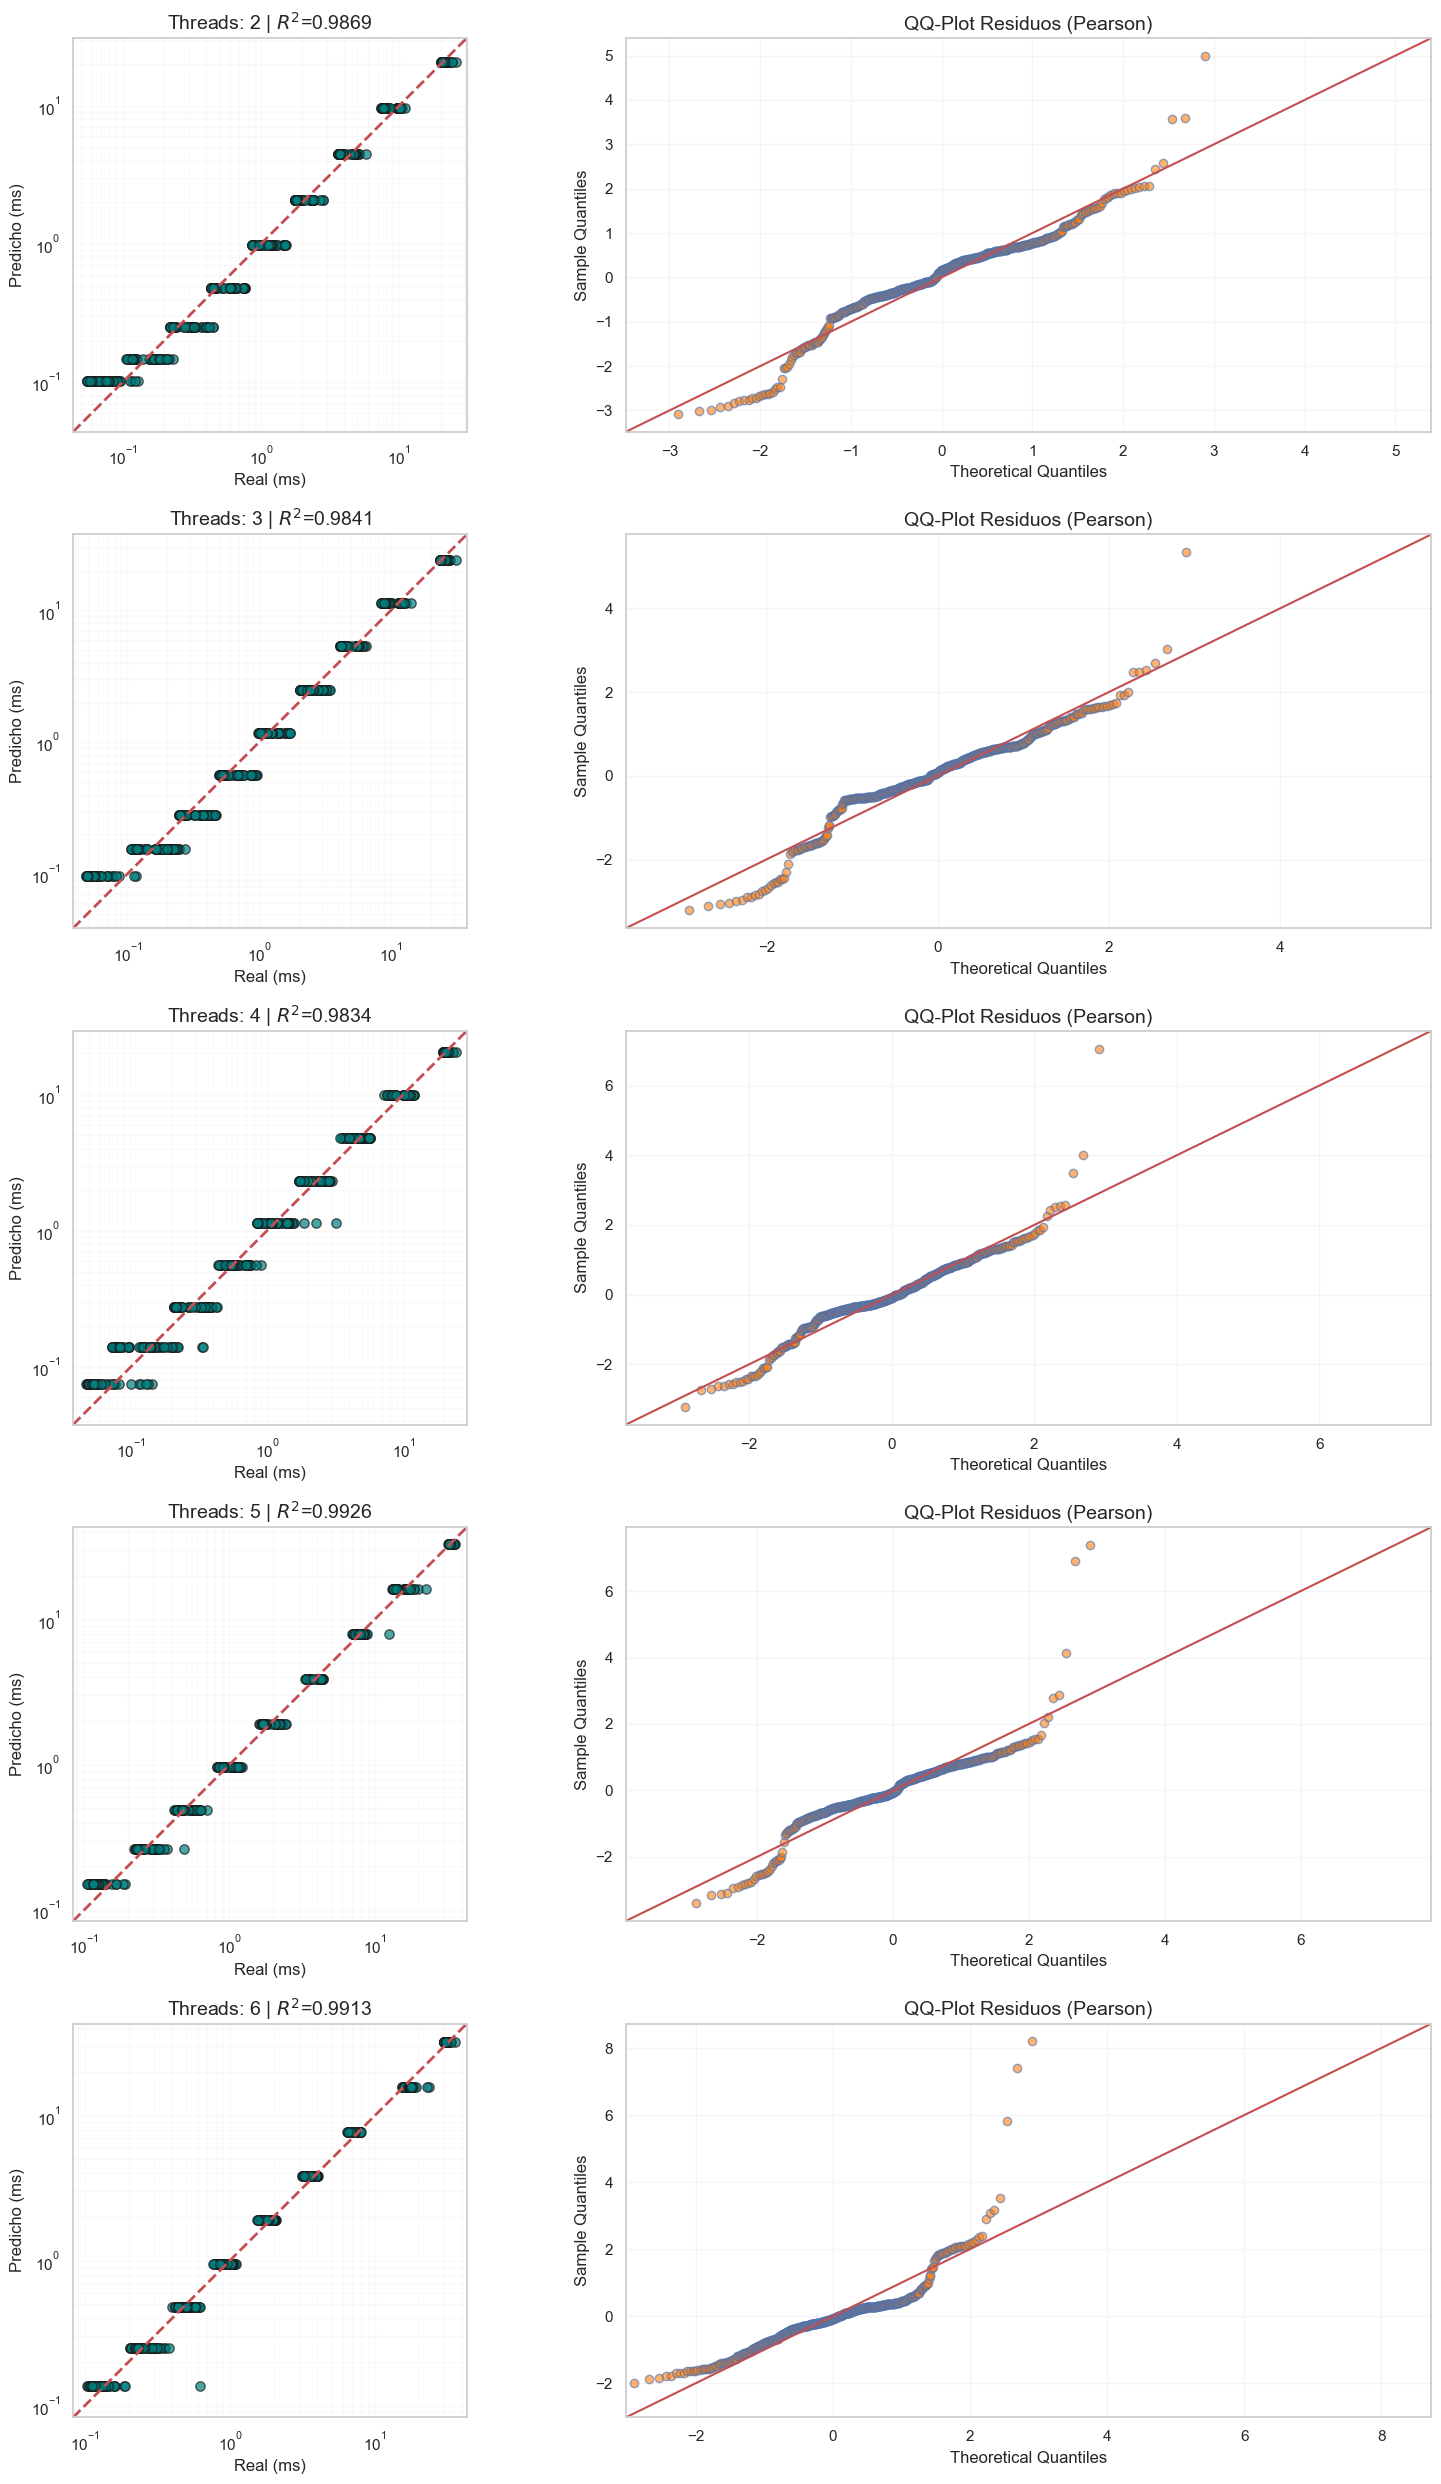


--- TABLA: COEFICIENTES POR MODELO (THREADS) ---
   Threads        R2     const        X_sort   X_merge
0        2  0.986949  0.066687  6.941429e-07 -0.000005
1        3  0.984068  0.051685  1.133472e-06 -0.000004
2        4  0.983394  0.013614  5.490806e-07  0.000004
3        5  0.992552  0.045115  9.344280e-07  0.000009
4        6  0.991289  0.027812  7.492554e-07  0.000012


In [115]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


def analizar_paralelo_con_qqplots(df_granular):
    # 1. Filtro estricto: Solo paralelo y zona segura de L3
    df = df_granular[(df_granular['Threads'] > 1) &
                     (df_granular['InputSize'] > 10000) &
                     (df_granular['InputSize'] < 4200000)].copy()

    threads = sorted(df['Threads'].unique())
    n_threads = len(threads)

    # Generamos una fila por cada Thread para comparar Scatter vs QQ-plot
    fig, axes = plt.subplots(n_threads, 2, figsize=(16, 5 * n_threads))

    # Solo agrandar tipografía (no el tamaño del gráfico)
    title_fs = 14
    label_fs = 12
    tick_fs = 11

    resumen = []

    for i, k in enumerate(threads):
        df_k = df[df['Threads'] == k].copy()
        n = df_k['InputSize']

        # Modelo: Tiempo ~ b0 + b1*(n/k log n/k) + b2*(n/k log k)
        df_k['X_sort'] = (n / k) * np.log2(n / k)
        df_k['X_merge'] = (n / k) * np.log2(k)

        y = df_k['TotalTime']
        X = sm.add_constant(df_k[['X_sort', 'X_merge']])

        # WLS con pesos 1/n para normalizar la varianza
        res_wls = sm.WLS(y, X, weights=1.0/n).fit()

        # --- LADO IZQUIERDO: AJUSTE VISUAL (Log-Log) ---
        ax_reg = axes[i, 0]
        y_pred = res_wls.predict(X)
        ax_reg.scatter(y, y_pred, alpha=0.7, color='teal', edgecolors='k', s=45)

        # Diagonal de identidad normalizada
        ax_reg.set_xscale('log')
        ax_reg.set_yscale('log')
        mn, mx = min(y.min(), y_pred.min())*0.8, max(y.max(), y_pred.max())*1.2
        ax_reg.set_xlim(mn, mx)
        ax_reg.set_ylim(mn, mx)
        ax_reg.plot([mn, mx], [mn, mx], 'r--', lw=2)
        ax_reg.set_aspect('equal')

        ax_reg.set_title(f"Threads: {k} | $R^2$={res_wls.rsquared:.4f}", fontsize=title_fs)
        ax_reg.set_xlabel("Real (ms)", fontsize=label_fs)
        ax_reg.set_ylabel("Predicho (ms)", fontsize=label_fs)
        ax_reg.tick_params(axis='both', which='both', labelsize=tick_fs)
        ax_reg.grid(True, which="both", alpha=0.1)

        # --- LADO DERECHO: QQ-PLOT (Normalidad de Residuos de Pearson) ---
        ax_qq = axes[i, 1]
        sm.qqplot(res_wls.resid_pearson, line='45', ax=ax_qq, markerfacecolor='tab:orange', alpha=0.6)

        ax_qq.set_title("QQ-Plot Residuos (Pearson)", fontsize=title_fs)
        ax_qq.set_xlabel(ax_qq.get_xlabel(), fontsize=label_fs)
        ax_qq.set_ylabel(ax_qq.get_ylabel(), fontsize=label_fs)
        ax_qq.tick_params(axis='both', which='both', labelsize=tick_fs)
        ax_qq.grid(True, alpha=0.2)

        row = {'Threads': k, 'R2': res_wls.rsquared}
        row.update(res_wls.params.to_dict())
        resumen.append(row)

    plt.tight_layout()
    plt.show()

    # Tabla final: coeficientes por modelo (cada Threads es un modelo)
    df_betas = pd.DataFrame(resumen)
    cols_pref = ['Threads', 'R2', 'const', 'X_sort', 'X_merge']
    ordered_cols = [c for c in cols_pref if c in df_betas.columns] + [c for c in df_betas.columns if c not in cols_pref]
    df_betas = df_betas[ordered_cols]

    print("\n--- TABLA: COEFICIENTES POR MODELO (THREADS) ---")
    print(df_betas)

    return df_betas


df_betas = analizar_paralelo_con_qqplots(df_granular)


In [99]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def regresion_robusta_magister(df_granular):
    # 1. Filtro estricto (Threads > 1 y régimen L3 seguro)
    # Excluimos T=1 porque el comportamiento paralelo es el objetivo del estudio
    df = df_granular[(df_granular['Threads'] > 1) &
                     (df_granular['InputSize'] > 10000) &
                     (df_granular['InputSize'] < 4200000)].copy()

    threads = sorted(df['Threads'].unique())

    for k in threads:
        df_k = df[df['Threads'] == k].copy()

        n = df_k['InputSize']
        df_k['X_sort'] = (n / k) * np.log2(n / k)
        df_k['X_merge'] = (n / k) * np.log2(k)

        # 2. Preparación de matrices
        X = sm.add_constant(df_k[['X_sort', 'X_merge']])
        y = df_k['TotalTime']

        # 3. Ajuste WLS (Mínimos Cuadrados Ponderados)
        # Usamos pesos 1/n para mitigar la heterocedasticidad demostrada
        model = sm.WLS(y, X, weights=1.0/n)

        # --- RIGOR ESTADÍSTICO: Errores Estándar Robustos (HC3) ---
        # HC3 es preferible en muestras pequeñas/medianas para manejar
        # la falta de normalidad y outliers sistemáticos.
        res = model.fit(cov_type='HC3')

        print(f"\n{'='*20} RESULTADOS ROBUSTOS (THREADS {k}) {'='*20}")
        print(f"R^2: {res.rsquared:.4f} | AIC: {res.aic:.2f}")
        print("\nCoeficientes:")
        print(res.params)
        print("\nErrores estándar (HC3):")
        print(res.bse)

# Ejecución
regresion_robusta_magister(df_granular)


==================== RESULTADOS ROBUSTOS (THREADS 2) ====================
R^2: 0.9869 | AIC: 62.10

Coeficientes:
const      6.668718e-02
X_sort     6.941429e-07
X_merge   -4.749731e-06
dtype: float64

Errores estándar (HC3):
const      5.366207e-03
X_sort     4.312456e-08
X_merge    8.693113e-07
dtype: float64

==================== RESULTADOS ROBUSTOS (THREADS 3) ====================
R^2: 0.9841 | AIC: 351.42

Coeficientes:
const      0.051685
X_sort     0.000001
X_merge   -0.000004
dtype: float64

Errores estándar (HC3):
const      7.001361e-03
X_sort     8.293722e-08
X_merge    1.025654e-06
dtype: float64

==================== RESULTADOS ROBUSTOS (THREADS 4) ====================
R^2: 0.9834 | AIC: 207.75

Coeficientes:
const      1.361406e-02
X_sort     5.490806e-07
X_merge    4.177159e-06
dtype: float64

Errores estándar (HC3):
const      5.815290e-03
X_sort     9.508779e-08
X_merge    9.311833e-07
dtype: float64

==================== RESULTADOS ROBUSTOS (THREADS 5) ==============

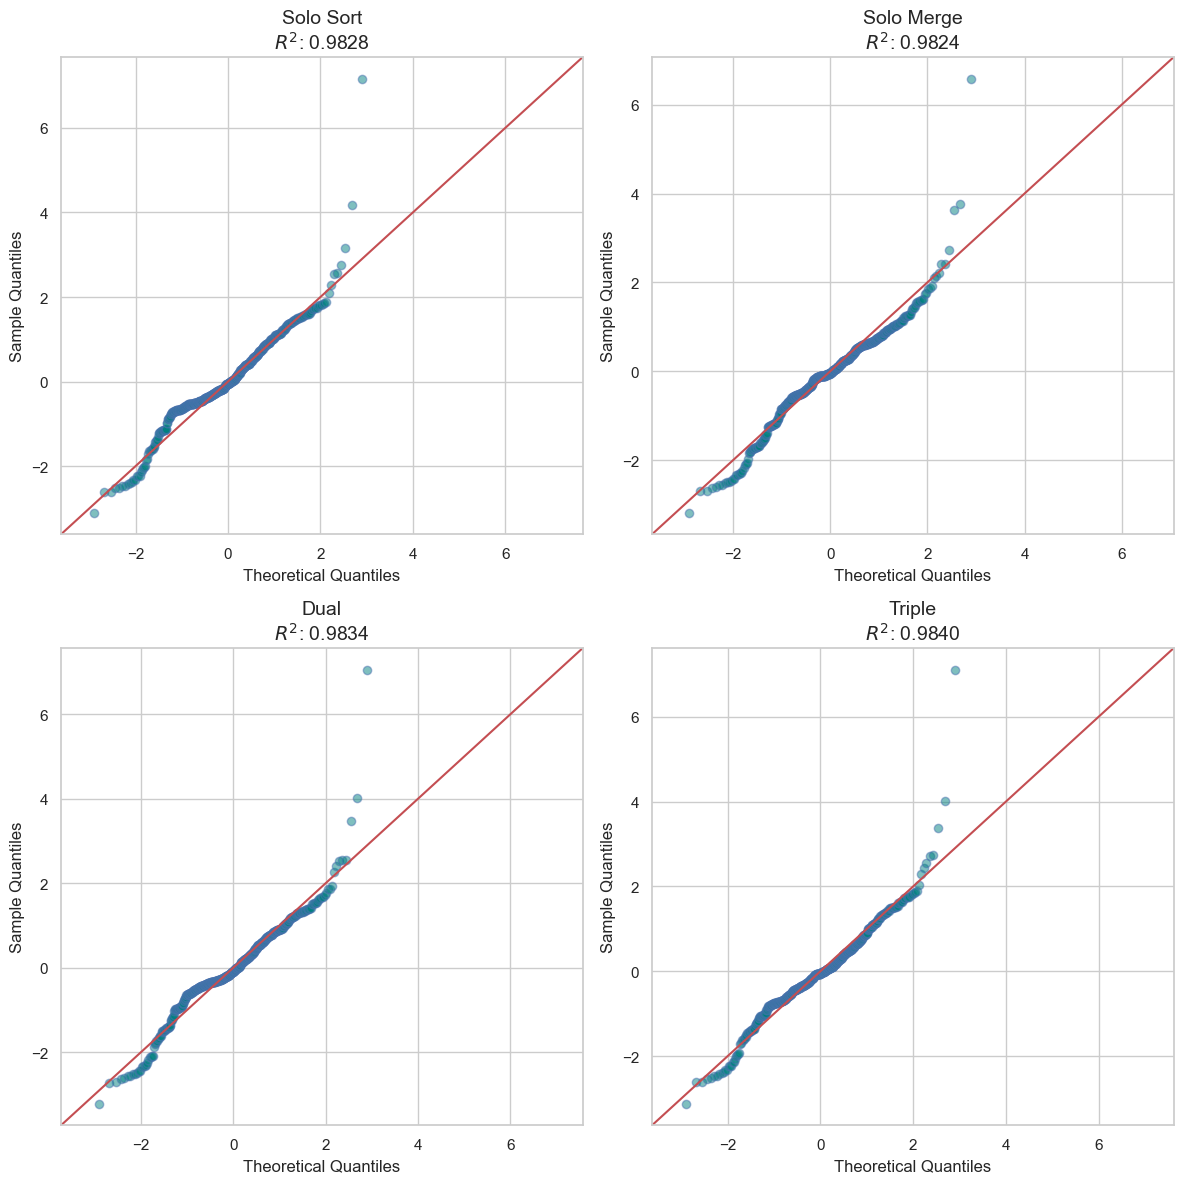

--- TABLA 1: MÉTRICAS DE AJUSTE ---
       Modelo        R2         AIC       Cond_No           JB_p
0   Solo Sort  0.982806  224.543888  1.285983e+06  3.265955e-130
1  Solo Merge  0.982447  235.698758  1.366083e+05  6.356547e-189
2        Dual  0.983394  207.753119  1.729227e+06  9.864479e-181
3      Triple  0.983963  190.895582  2.871535e+07  6.922989e-151

--- TABLA 2: COEFICIENTES ORIGINALES (ms/operación teórica) ---
               const        X_sort   X_merge  X_run_class
Modelo                                                   
Solo Sort   0.040242  9.811096e-07       NaN          NaN
Solo Merge -0.019626           NaN  0.000009          NaN
Dual        0.013614  5.490806e-07  0.000004          NaN
Triple     -0.640654  1.269626e-06 -0.000003     0.013714

--- TABLA 3: COEFICIENTES NORMALIZADOS (Importancia relativa) ---
                   const    X_sort   X_merge  X_run_class
Modelo                                                   
Solo Sort  -8.504716e-04  1.001314       Na

In [109]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats


def evaluar_modelos_competidores(df_granular):
    # 1. Preparación de datos (Threads=4, Régimen L3)
    df = df_granular[(df_granular['Threads'] == 4) &
                     (df_granular['InputSize'] > 10000) &
                     (df_granular['InputSize'] < 4200000)].copy()

    n = df['InputSize']
    k = 4
    df['X_sort'] = (n / k) * np.log2(n / k)
    df['X_merge'] = (n / k) * np.log2(k)
    df['X_run_class'] = k * np.log2(n / k)
    y = df['TotalTime']

    modelos = {
        "Solo Sort": ['X_sort'],
        "Solo Merge": ['X_merge'],
        "Dual": ['X_sort', 'X_merge'],
        "Triple": ['X_sort', 'X_merge', 'X_run_class']
    }

    # Contenedores para las 4 tablas
    res_metricas = []
    res_coef_raw = []
    res_coef_norm = []

    # Tipografías más grandes para los gráficos
    title_fs = 14
    label_fs = 12
    tick_fs = 11

    # 2x2 (cuadrícula) para los 4 gráficos
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for i, (nombre, predictores) in enumerate(modelos.items()):
        # --- MODELO ORIGINAL (RAW) ---
        X = sm.add_constant(df[predictores])
        res = sm.WLS(y, X, weights=1.0/n).fit(cov_type='HC3')

        # --- MODELO NORMALIZADO (STANDARDIZED) ---
        # Escalamos variables (mean=0, std=1) para obtener Betas comparables
        df_norm = df[predictores].apply(lambda x: (x - x.mean()) / x.std())
        y_norm = (y - y.mean()) / y.std()
        X_norm = sm.add_constant(df_norm)
        res_norm = sm.WLS(y_norm, X_norm, weights=1.0/n).fit(cov_type='HC3')

        # 1. Tabla de Métricas
        res_metricas.append({
            'Modelo': nombre,
            'R2': res.rsquared,
            'AIC': res.aic,
            'Cond_No': res.condition_number,
            'JB_p': stats.jarque_bera(res.resid)[1]
        })

        # 2. Tabla de Coeficientes Raw
        c_raw = res.params.to_dict()
        c_raw['Modelo'] = nombre
        res_coef_raw.append(c_raw)

        # 3. Tabla de Coeficientes Normalizados (Importancia Relativa)
        c_norm = res_norm.params.to_dict()
        c_norm['Modelo'] = nombre
        res_coef_norm.append(c_norm)

        # Gráfico (QQ-plot)
        ax = axes[i]
        sm.qqplot(res.resid_pearson, line='45', ax=ax, markerfacecolor='teal', alpha=0.5)
        ax.set_title(f"{nombre}\n$R^2$: {res.rsquared:.4f}", fontsize=title_fs)
        ax.set_xlabel(ax.get_xlabel(), fontsize=label_fs)
        ax.set_ylabel(ax.get_ylabel(), fontsize=label_fs)
        ax.tick_params(axis='both', labelsize=tick_fs)

    plt.tight_layout()
    plt.show()

    # Generar DataFrames finales
    df_metricas = pd.DataFrame(res_metricas)
    df_raw = pd.DataFrame(res_coef_raw).set_index('Modelo')
    df_norm = pd.DataFrame(res_coef_norm).set_index('Modelo')

    return df_metricas, df_raw, df_norm


# Ejecución y visualización de las tablas
tab_met, tab_raw, tab_norm = evaluar_modelos_competidores(df_granular)

print("--- TABLA 1: MÉTRICAS DE AJUSTE ---")
print(tab_met)
print("\n--- TABLA 2: COEFICIENTES ORIGINALES (ms/operación teórica) ---")
print(tab_raw)
print("\n--- TABLA 3: COEFICIENTES NORMALIZADOS (Importancia relativa) ---")
print(tab_norm)


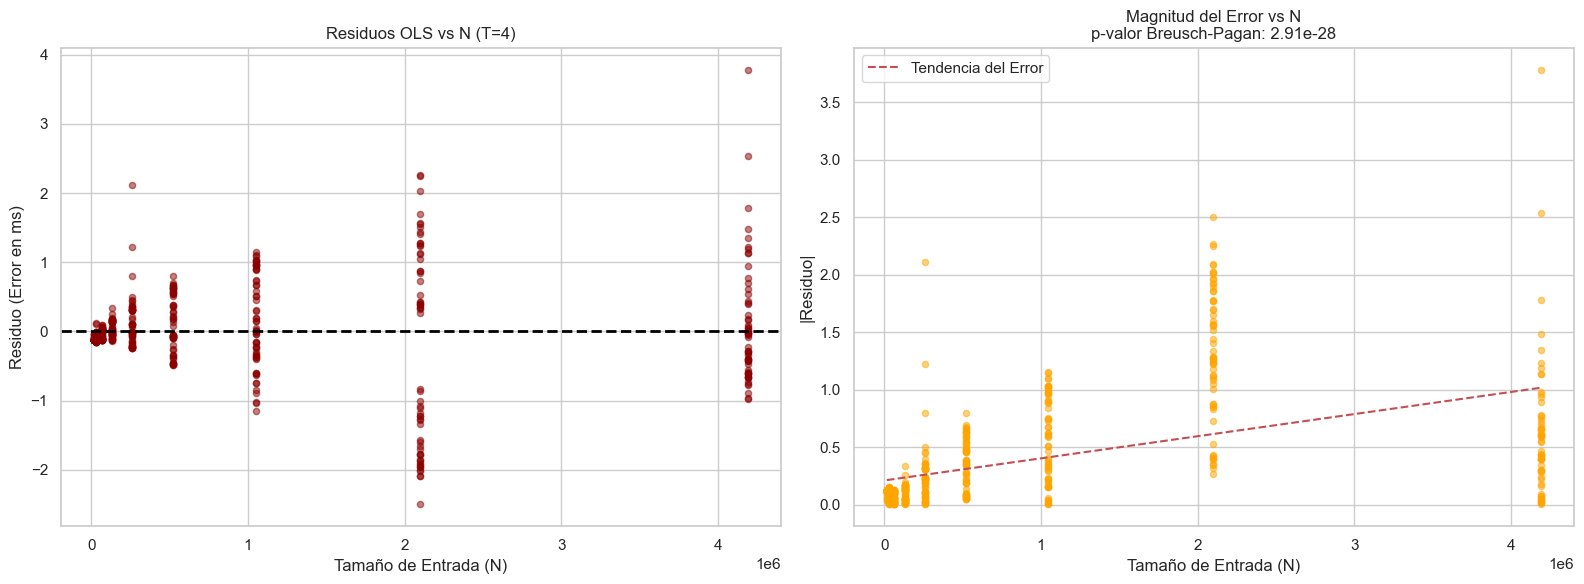

Resultado Test Breusch-Pagan (p-valor): 2.906293916199944e-28


In [102]:
def demostrar_heterocedasticidad(df_granular, t=4):
    # 1. Filtro y preparación (Usamos OLS sin pesos para ver el error real)
    df = df_granular[(df_granular['Threads'] == t) & 
                     (df_granular['InputSize'] > 10000) & 
                     (df_granular['InputSize'] < 4200000)].copy()
    
    n = df['InputSize']
    df['X_sort'] = (n / t) * np.log2(n / t)
    df['X_merge'] = (n / t) * np.log2(t)
    
    X = sm.add_constant(df[['X_sort', 'X_merge']])
    y = df['TotalTime']
    
    # 2. Ajuste OLS (Sin pesos)
    modelo_ols = sm.OLS(y, X).fit()
    residuos = modelo_ols.resid
    
    # 3. Test de Breusch-Pagan
    # Retorna: (LM statistic, LM p-value, F-statistic, F p-value)
    bp_test = het_breuschpagan(residuos, X)
    
    # 4. Visualización
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico A: Residuos vs N (Forma de abanico)
    ax[0].scatter(n, residuos, alpha=0.5, color='darkred', s=20)
    ax[0].axhline(0, color='black', lw=2, ls='--')
    ax[0].set_title(f"Residuos OLS vs N (T={t})")
    ax[0].set_xlabel("Tamaño de Entrada (N)")
    ax[0].set_ylabel("Residuo (Error en ms)")
    
    # Gráfico B: Valor Absoluto de Residuos (Tendencia de la varianza)
    ax[1].scatter(n, np.abs(residuos), alpha=0.5, color='orange', s=20)
    # Línea de tendencia simple para mostrar el crecimiento
    z = np.polyfit(n, np.abs(residuos), 1)
    p = np.poly1d(z)
    ax[1].plot(n, p(n), "r--", label="Tendencia del Error")
    ax[1].set_title(f"Magnitud del Error vs N\np-valor Breusch-Pagan: {bp_test[1]:.2e}")
    ax[1].set_xlabel("Tamaño de Entrada (N)")
    ax[1].set_ylabel("|Residuo|")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Resultado Test Breusch-Pagan (p-valor): {bp_test[1]}")

demostrar_heterocedasticidad(df_granular)